# Mock for Song

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

We want to take an N-body simulation (currently MDPL but could be anything) and put galaxies in it in a way that creates a universe consistent with HSC observations. We are building an HSC mock catalog.

To do this we use the functional form which relates stellar mass to halo mass from [Behroozi2010](https://arxiv.org/pdf/1001.0015.pdf). As this is a mean relation we will also need a scatter term which we allow to vary linearly with log(halo mass). Finally, we get a good starting fit for the Behroozi functional form from [Leauthaud2012](https://arxiv.org/pdf/1104.0928.pdf) and for the scatter term from CB in prep.

As this functional form relates stellar mass - halo mass we initially generated stellar masses using various halo masses (Mvir, Mpeak). We were able to fit the SMF but clustering was low. After talking to Peter, this is apparently known and we should instead be populating stellar mass using Vmax@Mpeak. See [appendix A](./appendix.ipynb) for a description of how we get the initial coordinates.

With these initial fits we run an optimizer that takes into account both the SM and the clustering. We find that we can match the SMF well (all bins within the error bars) but have low clustering (HSC is 18.5 +/- 1.7, mock is 14 +/- 0.2). I don't really know how to evaluate whether this is good enough.

### How to run this

* If you want to re-run the opimizer, just run everything though  (takes O(hours)).
* If you just want to build the best fit model, run everything except the optimizer (takes O(1 minute)).

## Import etc...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize

import data as d
import likelihood as l
import plots as p
import clustering as c

import emcee
from pyDOE import lhs

import smhm_fit
from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf
import GPy
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from scipy.stats.distributions import norm
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data + initial config

In [3]:
# For the clustering, we look around objects with mass greater than this and
# count objects in the 0.1 dex smaller than it.
cen_sat_div = [11.65, 11.75, 11.85]

# [ 2.37998488, 10.92042303,  0.35623719,  0.18581664,  0.27877097, -0.11090357,  0.51954824]
# ^ Were the results from the very long run with ... some config (I don't really remember...)
# But I now needed to restart to get memory.

# See the appendix A for how we got these starting params
b_params = [2.4, 10.91, 0.6, 0.2, 0.2]
s_params = [-0.1, 0.5]
params = b_params + s_params
x_field = "Vmax@Mpeak"

# To speed things up we store a previous best_fit
best_fit = params = [ 2.37998488, 10.92042303,  0.35623719,  0.18581664,  0.27877097, -0.11090357,  0.51954824]

In [4]:
# The simulation data
sim_data, sim_size = d.load_mdpl()
print(np.log10(np.min(sim_data["halo_mvir"])))

# The observational data that we fit to
hsc_gals = d.load_hsc_gals()
obs_clust = np.array(
    [c.compute_hsc_clustering(hsc_gals, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
obs_smf = d.load_smf()

11.169422622696432
[Memory]5.5s, 0.1min    : Loading compute_hsc_clustering...
[Memory]5.5s, 0.1min    : Loading compute_hsc_clustering...
[Memory]5.5s, 0.1min    : Loading compute_hsc_clustering...


 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/joblib/hashing.py:212: FutureWarning:Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


# Find bestfit to SMF with optimizer

In [ ]:
res = scipy.optimize.minimize(
    l.compute_chi2_n,
    x0 = params,
    args=(sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 3),
    method="Nelder-Mead",
)
assert res.success == True
best_fit = res.x

[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824] 2.047974372516754
[ 2.49898412 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824] 287.4558895771229
[ 2.37998488 11.46644418  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824] 932694.4411151003
[ 2.37998488 10.92042303  0.37404905  0.18581664  0.27877097 -0.11090357  0.51954824] 2.9115744045057492
[ 2.37998488 10.92042303  0.35623719  0.19510747  0.27877097 -0.11090357  0.51954824] 2.905680652491643
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.29270952 -0.11090357  0.51954824] 2.2966063655056312
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11644875  0.51954824] 22.936216957802213
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.54552565] 113.510966372972
[ 2.41398466 10.37440188  0.36132629  0.18847116  0.28275341 -0.11248791  0.52697036] 

# MCMC

## GP training

In [5]:
ranges = np.array([
    [2.3, 2.5],
    [10.7, 11.2],
    [0.3, 0.4],
    [0.1, 0.3],
    [0.2, 0.4],
    #[-0.15, -0.8],
    #[0.6, 0.4],
])

samples = ranges[:,0] + (ranges[:,1] - ranges[:,0]) * lhs(len(ranges), samples=10000)
samples = np.append(samples, np.ones((len(samples), 2)) * np.array([best_fit[-2], best_fit[-1]]), axis=1)

In [6]:
def f(params):
    return l.compute_chi2_n(params, sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 1)

with Pool(6) as p:
    chi2 = p.map(f, samples)
chi2 = np.array(chi2)

# 6 in 15s, 25 in 1m, 1500 in 1h, 10 000 overnight!

[ 2.47524897 10.86402081  0.3274574   0.29660506  0.29960604 -0.11090357  0.51954824] 345.21987770523066
[ 2.33181786 10.95915495  0.37369269  0.26770388  0.30994908 -0.11090357  0.51954824] 214.33524493462647
[ 2.32741924 10.72297986  0.37943568  0.2600423   0.3186832  -0.11090357  0.51954824] 322.9399480316129
[ 2.48699172 10.9557201   0.36072101  0.10970881  0.38222585 -0.11090357  0.51954824] 153.31322286824397
[ 2.36089752 11.018259    0.34567285  0.27830246  0.30899115 -0.11090357  0.51954824] 540.2722504622471
[ 2.33518738 11.02363     0.31161367  0.26091384  0.28348044 -0.11090357  0.51954824] 1824.7896488391393
[ 2.4131294  10.8635517   0.39781801  0.17082062  0.25344935 -0.11090357  0.51954824] 161.85117823968415
[ 2.45829128 10.70409973  0.32693559  0.13249894  0.38437012 -0.11090357  0.51954824] 412.6250877676441
[ 2.35944227 10.75139601  0.39807181  0.25663029  0.22535666 -0.11090357  0.51954824] 309.02351401496827
[ 2.47158341 11.12276843  0.39661489  0.26197167  0.318666

[ 2.35825496 10.82780079  0.34097963  0.18623582  0.30130814 -0.11090357  0.51954824] 87.02534034569099
[ 2.35123549 10.70536407  0.38689804  0.27131911  0.37162451 -0.11090357  0.51954824] 372.18483534209764
[ 2.34296105 11.10728448  0.30840556  0.2505953   0.24089568 -0.11090357  0.51954824] 9759.913276286461
[ 2.34719466 10.8453324   0.35866359  0.21188288  0.29610708 -0.11090357  0.51954824] 64.82624329751391
[ 2.48020093 10.88066195  0.39338886  0.17795359  0.35335395 -0.11090357  0.51954824] 329.8542770414626
[ 2.30859921 10.73982678  0.30029185  0.28671206  0.38452644 -0.11090357  0.51954824] 263.79762102430186
[ 2.32983124 10.90666319  0.39608726  0.11279932  0.3192817  -0.11090357  0.51954824] 266.5859106642645
[ 2.40432532 11.07107658  0.39552491  0.20731975  0.23421924 -0.11090357  0.51954824] 906.0002845698871
[ 2.46254905 10.79027767  0.34895443  0.24382911  0.27910544 -0.11090357  0.51954824] 384.74387291114715
[ 2.47185124 10.95724857  0.32460872  0.20136923  0.26087539 

[ 2.34615462 11.03190753  0.33237185  0.2347975   0.32250985 -0.11090357  0.51954824] 1632.9182476880524
[ 2.49404057 11.02837818  0.38631241  0.27508241  0.22025214 -0.11090357  0.51954824] 71.88650921938613
[ 2.47385681 10.81686841  0.38595227  0.20742082  0.3651148  -0.11090357  0.51954824] 371.7654120821561
[ 2.42245691 10.88624903  0.30128966  0.26098371  0.2287837  -0.11090357  0.51954824] 156.21294924004889
[ 2.34180429 11.08856914  0.39713269  0.28799773  0.21527674 -0.11090357  0.51954824] 5356.0074578908625
[ 2.37887611 10.94927011  0.33401807  0.25532134  0.33546224 -0.11090357  0.51954824] 15.875238187584486
[ 2.3140307  10.7022989   0.35663059  0.11637465  0.23544522 -0.11090357  0.51954824] 87.62411893827309
[ 2.41919292 10.96620186  0.35747221  0.29640119  0.37309796 -0.11090357  0.51954824] 71.24778355436725
[ 2.47379017 11.04816335  0.30337665  0.12188081  0.32585    -0.11090357  0.51954824] 125.97242070393435
[ 2.48953969 10.70684857  0.32308234  0.12331601  0.2764257

[ 2.3275228  11.05477137  0.34229842  0.12184587  0.33324899 -0.11090357  0.51954824] 10109.68781220667
[ 2.36303382 10.94983737  0.37673297  0.1236602   0.34620962 -0.11090357  0.51954824] 208.27222957709924
[ 2.45021237 11.19899133  0.38107524  0.26812301  0.36870563 -0.11090357  0.51954824] 3945.0186164803736
[ 2.36319108 11.12435276  0.32116818  0.23984273  0.21628397 -0.11090357  0.51954824] 8987.755744721693
[ 2.32749651 10.87761749  0.35605365  0.1725983   0.35249311 -0.11090357  0.51954824] 10.378039020420456
[ 2.48121598 10.84764803  0.37114637  0.13318702  0.20912324 -0.11090357  0.51954824] 321.4560205275444
[ 2.31651309 10.92689824  0.38434888  0.1796682   0.22847972 -0.11090357  0.51954824] 547.9913221643345
[ 2.46143954 10.76019756  0.35067612  0.18568831  0.2047008  -0.11090357  0.51954824] 381.83759347397233
[ 2.43257846 11.04022855  0.36779796  0.16290305  0.22380282 -0.11090357  0.51954824] 264.84565692200107
[ 2.39289099 10.92503448  0.34060443  0.26835651  0.2897099

[ 2.45138604 10.78013222  0.34959264  0.1907012   0.32509583 -0.11090357  0.51954824] 383.2059591459563
[ 2.32390463 11.10068245  0.38407308  0.17816232  0.32342172 -0.11090357  0.51954824] 13136.431905627804
[ 2.38704221 10.83204313  0.39716802  0.21180071  0.39780269 -0.11090357  0.51954824] 233.432962468401
[ 2.40821074 11.18291231  0.33739831  0.13256643  0.3144257  -0.11090357  0.51954824] 12637.642705784976
[ 2.44587039 10.83983042  0.36711218  0.2639052   0.24682341 -0.11090357  0.51954824] 314.93310461222586
[ 2.41227091 10.80875984  0.34995576  0.18688215  0.28845204 -0.11090357  0.51954824] 278.2256161282218
[ 2.46619177 10.86646492  0.32612927  0.21885036  0.3713219  -0.11090357  0.51954824] 311.1677483083909
[ 2.36242643 10.71412963  0.31884778  0.23953388  0.39949527 -0.11090357  0.51954824] 366.6197812725947
[ 2.48877629 10.97690858  0.3895065   0.15791626  0.25102768 -0.11090357  0.51954824] 109.14139994976276
[ 2.36086459 10.85314094  0.39854688  0.13340392  0.34544511 

[ 2.42705974 11.00280739  0.31766702  0.21540695  0.35076936 -0.11090357  0.51954824] 5.795741917489529
[ 2.44807666 10.86021262  0.36348715  0.24634207  0.38199723 -0.11090357  0.51954824] 304.6321810822624
[ 2.37006117 10.7385008   0.33552677  0.14557026  0.20985072 -0.11090357  0.51954824] 189.0783638596991
[ 2.3568466  10.88458778  0.37340763  0.21163953  0.28621487 -0.11090357  0.51954824] 23.50724416264999
[ 2.47600357 11.14661543  0.35764551  0.17859595  0.30098591 -0.11090357  0.51954824] 680.3627770543927
[ 2.35559433 10.75590633  0.35460994  0.14074017  0.36253483 -0.11090357  0.51954824] 228.38109140551333
[ 2.41038788 11.00457694  0.31411139  0.12958302  0.36319351 -0.11090357  0.51954824] 270.3866536477075
[ 2.44093658 10.96061838  0.35278884  0.10765472  0.29145792 -0.11090357  0.51954824] 27.92771334023382
[ 2.36286872 10.71292734  0.37866315  0.18802609  0.38424808 -0.11090357  0.51954824] 352.45213405118596
[ 2.47082151 10.97120993  0.3253798   0.2291763   0.36371834 -

[ 2.47744447 11.07755487  0.35429992  0.29300598  0.33746313 -0.11090357  0.51954824] 23.792614694374393
[ 2.40636933 10.8288173   0.32173137  0.29286245  0.21446437 -0.11090357  0.51954824] 267.6179719024294
[ 2.40727231 10.82175265  0.3930417   0.24997156  0.36723695 -0.11090357  0.51954824] 294.5569271655913
[ 2.46829177 11.06940486  0.35145937  0.2040645   0.32043769 -0.11090357  0.51954824] 29.553567031069164
[ 2.46815413 11.16942757  0.3997449   0.27781351  0.3255364  -0.11090357  0.51954824] 1265.1686004126007
[ 2.31740696 10.71169525  0.32180497  0.26691633  0.37425131 -0.11090357  0.51954824] 306.4726790779367
[ 2.37814857 10.70379919  0.38904669  0.1224595   0.33862802 -0.11090357  0.51954824] 359.225712501762
[ 2.34358486 10.91118284  0.35510426  0.15875172  0.38325085 -0.11090357  0.51954824] 37.03961523999242
[ 2.44626682 10.80795165  0.38348173  0.2040579   0.29022806 -0.11090357  0.51954824] 339.40849517979825
[ 2.31342488 11.14930291  0.35124831  0.15116075  0.23878476 

[ 2.47584293 10.99886838  0.32966399  0.23058359  0.38506589 -0.11090357  0.51954824] 86.0010012000352
[ 2.47090499 10.740884    0.3356918   0.17223586  0.38029052 -0.11090357  0.51954824] 397.99763798726883
[ 2.4281611  10.79636933  0.36563422  0.17878537  0.32209336 -0.11090357  0.51954824] 324.1227034190134
[ 2.43961217 11.08737243  0.34936608  0.22408846  0.3021991  -0.11090357  0.51954824] 345.4900082898903
[ 2.35828676 11.18597715  0.32614434  0.21584546  0.26046127 -0.11090357  0.51954824] 28013.65712631358
[ 2.39522517 11.00893793  0.32770577  0.20416923  0.32121243 -0.11090357  0.51954824] 191.1523638478184
[ 2.33599115 10.74597428  0.34934966  0.15783786  0.31719882 -0.11090357  0.51954824] 182.45012018011116
[ 2.34740671 10.7697877   0.39216595  0.16940214  0.30454522 -0.11090357  0.51954824] 205.21688030292708
[ 2.30799734 10.87073778  0.3783744   0.28262569  0.22058828 -0.11090357  0.51954824] 24.287210628085244
[ 2.39689408 10.73305782  0.32787231  0.2269121   0.23118054 

[ 2.48466852 10.86283668  0.30007162  0.20562532  0.26429451 -0.11090357  0.51954824] 317.66686228764706
[ 2.44546459 10.97645269  0.34046901  0.12854147  0.37763704 -0.11090357  0.51954824] 12.402032305013284
[ 2.30938412 11.1092101   0.34080949  0.29919252  0.39755723 -0.11090357  0.51954824] 13884.19276384767
[ 2.30869336 10.75806563  0.31803393  0.24862273  0.28511258 -0.11090357  0.51954824] 159.81629303005363
[ 2.35340232 10.78073992  0.38250894  0.1857151   0.2130573  -0.11090357  0.51954824] 153.44010574175428
[ 2.39292988 11.16426553  0.37216042  0.13576999  0.27803983 -0.11090357  0.51954824] 12437.008155156367
[ 2.38552134 11.11890386  0.39022931  0.23411113  0.24273914 -0.11090357  0.51954824] 4035.3741902133165
[ 2.44500094 10.79197761  0.30120397  0.13762409  0.26352241 -0.11090357  0.51954824] 301.3365368203165
[ 2.4594178  10.86133205  0.3454981   0.28824197  0.36022529 -0.11090357  0.51954824] 321.957981065001
[ 2.32125017 11.10981825  0.32648377  0.28250001  0.2563602

[ 2.43536259 11.13450757  0.37718625  0.29874372  0.36920484 -0.11090357  0.51954824] 1281.9816189668072
[ 2.42698443 10.94802443  0.38791219  0.24271147  0.26590482 -0.11090357  0.51954824] 73.83353710809006
[ 2.31548541 10.99083271  0.36498332  0.11322539  0.24646151 -0.11090357  0.51954824] 6937.836811368144
[ 2.33790223 10.96074789  0.31103887  0.28942213  0.33899142 -0.11090357  0.51954824] 170.3507114647647
[ 2.39773576 11.0337292   0.39642608  0.11232075  0.38359881 -0.11090357  0.51954824] 564.425832790465
[ 2.35767731 11.00787262  0.30540734  0.157293    0.23592917 -0.11090357  0.51954824] 3017.2237327393473
[ 2.42465976 11.09799861  0.35609424  0.24970167  0.27074655 -0.11090357  0.51954824] 759.8378812260063
[ 2.36501523 10.90034909  0.31734489  0.23538321  0.31076245 -0.11090357  0.51954824] 17.77370747617063
[ 2.49895167 10.93816411  0.38045923  0.29335549  0.39074061 -0.11090357  0.51954824] 279.60978634667003
[ 2.30666846 11.09617856  0.33771807  0.12790974  0.38146133 -

[ 2.35256945 10.9838586   0.32716904  0.26313154  0.22264993 -0.11090357  0.51954824] 402.2823832731311
[ 2.33976185 10.94731213  0.38632703  0.24774151  0.36479861 -0.11090357  0.51954824] 85.63535021378448
[ 2.43618516 11.1169741   0.3881824   0.18945223  0.38083504 -0.11090357  0.51954824] 917.390764791197
[ 2.40766558 10.81762224  0.37068536  0.10265415  0.34695306 -0.11090357  0.51954824] 211.1874517985514
[ 2.34744032 11.19133982  0.33599872  0.26576719  0.28836612 -0.11090357  0.51954824] 30755.291067970957
[ 2.36206393 10.86428877  0.3336477   0.12194206  0.33832818 -0.11090357  0.51954824] 10.315547255077975
[ 2.36929514 11.16433525  0.31743271  0.2852646   0.28360793 -0.11090357  0.51954824] 12071.016101528327
[ 2.41714676 10.96567989  0.35116529  0.17489511  0.23791702 -0.11090357  0.51954824] 12.336000879649092
[ 2.38922139 11.11853152  0.38719202  0.18917191  0.30930468 -0.11090357  0.51954824] 3929.9457523967844
[ 2.3357438  10.89366116  0.37263521  0.21916189  0.25080488

[ 2.34984995 10.79712385  0.33514397  0.169218    0.32445711 -0.11090357  0.51954824] 115.83161965521651
[ 2.43206217 10.71751399  0.39405315  0.29897079  0.36130817 -0.11090357  0.51954824] 455.77759965770576
[ 2.32836746 10.9462378   0.31452453  0.29446707  0.28332432 -0.11090357  0.51954824] 164.8521844029189
[ 2.32389183 10.74530984  0.36466911  0.2779112   0.3138605  -0.11090357  0.51954824] 275.4575892172158
[ 2.42722455 10.87863072  0.34113812  0.18079066  0.3691283  -0.11090357  0.51954824] 191.92015709657107
[ 2.36254716 11.14394626  0.350199    0.2904316   0.32842741 -0.11090357  0.51954824] 9273.708380394428
[ 2.32114747 10.96917515  0.30558944  0.15925593  0.25288048 -0.11090357  0.51954824] 3343.2238720824216
[ 2.30159739 10.73596211  0.39929392  0.11037843  0.35529726 -0.11090357  0.51954824] 99.89592679172407
[ 2.30551906 11.10180945  0.33098362  0.12871803  0.30653847 -0.11090357  0.51954824] 37678.52698319434
[ 2.3583375  10.86553624  0.31701708  0.16935977  0.2456209 

[ 2.4416784  10.87101291  0.36263912  0.28173991  0.36660066 -0.11090357  0.51954824] 282.68112997628623
[ 2.48667414 11.12038622  0.34810232  0.28977091  0.3764748  -0.11090357  0.51954824] 107.69547155791673
[ 2.35998506 11.04060492  0.33153833  0.29001462  0.35650618 -0.11090357  0.51954824] 970.4515933904722
[ 2.41229807 11.08590411  0.33285019  0.17820451  0.21437878 -0.11090357  0.51954824] 2039.5564034831143
[ 2.30243752 11.10402756  0.30922655  0.16276586  0.35858699 -0.11090357  0.51954824] 28516.12372817861
[ 2.42550963 10.90597803  0.37399225  0.2938625   0.39513741 -0.11090357  0.51954824] 204.55708544555125
[ 2.4876819  10.90850285  0.35314883  0.24923158  0.27380597 -0.11090357  0.51954824] 282.48125570002907
[ 2.43834627 10.75766773  0.38551625  0.27046984  0.32082252 -0.11090357  0.51954824] 381.3962789084522
[ 2.46728431 11.18510517  0.377483    0.13082151  0.38023279 -0.11090357  0.51954824] 2363.576604073369
[ 2.36197896 10.96895433  0.30257416  0.24434281  0.2272485

[ 2.30878134 10.70878695  0.31871182  0.16347136  0.36061765 -0.11090357  0.51954824] 192.26018797809542
[ 2.34538539 11.19181293  0.32168396  0.21131645  0.21270771 -0.11090357  0.51954824] 45960.42440298616
[ 2.37168677 10.81740555  0.36427694  0.11414025  0.31973121 -0.11090357  0.51954824] 80.63315812500451
[ 2.47947937 10.87566389  0.32249557  0.18820997  0.24482411 -0.11090357  0.51954824] 285.9018609356864
[ 2.45286441 10.81704397  0.31986283  0.16710855  0.24245674 -0.11090357  0.51954824] 320.5118808730122
[ 2.46746229 11.05409444  0.35518889  0.14215311  0.35155265 -0.11090357  0.51954824] 32.229180697181526
[ 2.43136118 11.16832817  0.37189504  0.18174165  0.22435448 -0.11090357  0.51954824] 4603.008706787223
[ 2.38762742 10.79894449  0.39133108  0.1045956   0.30566601 -0.11090357  0.51954824] 171.76505375688978
[ 2.44818265 10.87925871  0.33068789  0.21689507  0.33081488 -0.11090357  0.51954824] 242.9364023230463
[ 2.42621042 10.75602244  0.35325038  0.28537086  0.24604372 

[ 2.32850544 10.76722574  0.38342923  0.20535086  0.2481806  -0.11090357  0.51954824] 168.9016459719335
[ 2.36409117 11.13590609  0.32133474  0.18531396  0.28945028 -0.11090357  0.51954824] 12561.74766817809
[ 2.35276494 10.82218421  0.37685026  0.11569586  0.25782232 -0.11090357  0.51954824] 20.442823026938726
[ 2.40921919 10.85452853  0.31895216  0.2976773   0.32513297 -0.11090357  0.51954824] 243.78423865370166
[ 2.43068762 10.71781357  0.35853802  0.12809691  0.38136859 -0.11090357  0.51954824] 397.21951168440773
[ 2.34066437 11.04784337  0.31405019  0.24256695  0.23052084 -0.11090357  0.51954824] 3556.065337177028
[ 2.44416732 11.1741631   0.34996411  0.1118197   0.24928744 -0.11090357  0.51954824] 6871.0991170535135
[ 2.41192322 11.05784699  0.3636024   0.16612567  0.36808126 -0.11090357  0.51954824] 492.19410018316546
[ 2.41310447 10.79505166  0.33894413  0.10007986  0.30101209 -0.11090357  0.51954824] 205.1869727216428
[ 2.47139457 10.80782495  0.38586838  0.15286754  0.2477125

[ 2.35181959 11.08513092  0.39094979  0.16266884  0.29293863 -0.11090357  0.51954824] 6072.787857661758
[ 2.35963443 10.81987248  0.3578819   0.24878529  0.32051977 -0.11090357  0.51954824] 188.8425346258686
[ 2.37714416 10.80029706  0.36298515  0.12995001  0.24681213 -0.11090357  0.51954824] 104.18025821227019
[ 2.49874774 11.07860947  0.36734961  0.14436768  0.32228087 -0.11090357  0.51954824] 10.410072966397289
[ 2.4780578  10.94115469  0.30410117  0.26839973  0.35822754 -0.11090357  0.51954824] 216.88761411236794
[ 2.35237002 10.77659017  0.39169714  0.15386472  0.29949875 -0.11090357  0.51954824] 176.03338062878638
[ 2.47937732 10.73389595  0.34825463  0.28013875  0.30242224 -0.11090357  0.51954824] 410.6458535548734
[ 2.44849219 10.9147522   0.33414609  0.24202166  0.23844184 -0.11090357  0.51954824] 163.51316319644604
[ 2.44723997 11.1148139   0.39208185  0.22718314  0.286688   -0.11090357  0.51954824] 579.141389255195
[ 2.40617868 10.84590548  0.37327991  0.26780183  0.3629094 

[ 2.31406471 11.031743    0.34001996  0.19061165  0.21868756 -0.11090357  0.51954824] 7454.983011423352
[ 2.45590307 10.78442637  0.32512572  0.14207152  0.25552033 -0.11090357  0.51954824] 392.8675204560422
[ 2.35437488 10.76484371  0.32746333  0.24561277  0.33099989 -0.11090357  0.51954824] 269.8439254028395
[ 2.35673062 10.97066925  0.38315833  0.21120092  0.39682621 -0.11090357  0.51954824] 128.16836711553333
[ 2.36838547 10.98598477  0.32944278  0.1206217   0.38737327 -0.11090357  0.51954824] 692.5633076029804
[ 2.37076696 10.94754578  0.30314341  0.25661638  0.35098788 -0.11090357  0.51954824] 16.976477025017378
[ 2.37142037 10.78529368  0.36021133  0.22789565  0.38071316 -0.11090357  0.51954824] 294.6161982486214
[ 2.37665877 10.758458    0.33587366  0.13407125  0.3170439  -0.11090357  0.51954824] 234.16999395112305
[ 2.35469694 11.19149717  0.31858266  0.2739456   0.29733851 -0.11090357  0.51954824] 26213.117024317286
[ 2.39525978 10.84924457  0.35428711  0.10082812  0.20645917

[ 2.47564532 10.83390285  0.31288728  0.26282073  0.37884946 -0.11090357  0.51954824] 361.76242467113144
[ 2.44620195 11.06740173  0.37923088  0.13651349  0.36255991 -0.11090357  0.51954824] 202.15140593071993
[ 2.34414913 10.75064259  0.38382144  0.15891933  0.39528478 -0.11090357  0.51954824] 252.93838272030857
[ 2.33515862 10.98779082  0.35665742  0.22506215  0.29195204 -0.11090357  0.51954824] 789.8675724898421
[ 2.33917856 10.71726965  0.3913652   0.29153628  0.38878145 -0.11090357  0.51954824] 350.2244983873367
[ 2.30149036 10.74315985  0.35713014  0.23118211  0.2413701  -0.11090357  0.51954824] 160.09402027671777
[ 2.48421865 11.05067335  0.33447641  0.2835525   0.27530807 -0.11090357  0.51954824] 20.272232721809026
[ 2.39510476 10.78977493  0.39244149  0.26908986  0.36563345 -0.11090357  0.51954824] 337.2348886471582
[ 2.40624108 10.81617774  0.38644513  0.1762389   0.39340764 -0.11090357  0.51954824] 280.12435157980224
[ 2.46075124 10.84885775  0.3728537   0.25620612  0.395141

[ 2.35089459 11.02399053  0.30040024  0.12374619  0.2699339  -0.11090357  0.51954824] 7020.833149546365
[ 2.42297747 11.077925    0.30621003  0.21798732  0.3984402  -0.11090357  0.51954824] 457.8610234665775
[ 2.47559063 11.15752244  0.35996062  0.29726373  0.27522432 -0.11090357  0.51954824] 657.4513202272412
[ 2.34224477 11.05685037  0.36519547  0.14828781  0.23616089 -0.11090357  0.51954824] 7298.738387972557
[ 2.48196788 11.10097626  0.31633545  0.16476879  0.37007097 -0.11090357  0.51954824] 123.23773564136572
[ 2.35726839 11.16858005  0.32851613  0.17425761  0.20910852 -0.11090357  0.51954824] 32947.1966937065
[ 2.30747692 11.04753758  0.37299762  0.10062311  0.3502176  -0.11090357  0.51954824] 13638.709078003661
[ 2.46698765 10.76197493  0.34539485  0.27087386  0.38983099 -0.11090357  0.51954824] 451.52047661512825
[ 2.4967971  10.81274109  0.36915564  0.12463556  0.25896222 -0.11090357  0.51954824] 409.93010786096124
[ 2.30967445 10.87197598  0.31643981  0.11777561  0.29803524 

[ 2.45027365 10.82589636  0.34240055  0.2080895   0.33518445 -0.11090357  0.51954824] 335.69549207956237
[ 2.38680845 11.07239956  0.30584882  0.22619274  0.3103718  -0.11090357  0.51954824] 1552.1597734430568
[ 2.36701373 11.04994643  0.35351855  0.1522551   0.31771867 -0.11090357  0.51954824] 2456.725676891517
[ 2.30127142 10.97103949  0.38226094  0.20788144  0.29766109 -0.11090357  0.51954824] 1474.0836126074614
[ 2.39176561 10.7824606   0.36657653  0.1173992   0.22300766 -0.11090357  0.51954824] 156.97277227856944
[ 2.30571663 10.87745035  0.33722291  0.1069878   0.36890311 -0.11090357  0.51954824] 543.5393759806193
[ 2.37283087 11.0093651   0.34296875  0.24290828  0.39584657 -0.11090357  0.51954824] 260.08339410206065
[ 2.48859467 10.99137032  0.39268027  0.22572695  0.32231204 -0.11090357  0.51954824] 134.6218735954628
[ 2.49879903 10.81779964  0.33281834  0.19004172  0.39711795 -0.11090357  0.51954824] 382.9048177047729
[ 2.4301979  10.72854112  0.304223    0.27313625  0.3868014

[ 2.43959519 11.11264709  0.33222561  0.29750604  0.23508913 -0.11090357  0.51954824] 624.1923015803628
[ 2.31036358 10.96813143  0.39649104  0.19302364  0.37922476 -0.11090357  0.51954824] 841.928572466613
[ 2.49534661 10.9204603   0.32719888  0.22422018  0.28161209 -0.11090357  0.51954824] 282.1572253559193
[ 2.31486995 10.78494844  0.3113175   0.14384783  0.35600591 -0.11090357  0.51954824] 19.907278776075508
[ 2.32465509 10.83858983  0.37230788  0.22778354  0.35230595 -0.11090357  0.51954824] 77.00744820338878
[ 2.39108458 11.04334165  0.33136866  0.22381553  0.20435848 -0.11090357  0.51954824] 918.3621444656706
[ 2.42711834 10.91195199  0.33420939  0.19616857  0.29432616 -0.11090357  0.51954824] 97.3744603268074
[ 2.34486825 10.73555658  0.35037346  0.10391275  0.24548317 -0.11090357  0.51954824] 87.06034352769973
[ 2.3669412  10.72140111  0.31120349  0.12323379  0.23046383 -0.11090357  0.51954824] 154.6202746251649
[ 2.35347855 10.77330061  0.31893696  0.14329659  0.22939872 -0.1

[ 2.42802341 11.04347491  0.34957825  0.21039659  0.28180918 -0.11090357  0.51954824] 140.7025366436045
[ 2.32503026 10.75117684  0.33131546  0.13562951  0.27907027 -0.11090357  0.51954824] 54.85772477483924
[ 2.41070921 10.7952244   0.39984869  0.10602568  0.28739826 -0.11090357  0.51954824] 262.5428244336321
[ 2.45917878 10.8695241   0.39317528  0.24175009  0.24405048 -0.11090357  0.51954824] 301.128334031501
[ 2.39459176 11.16221357  0.32988289  0.12135409  0.36133674 -0.11090357  0.51954824] 12327.89608104491
[ 2.42054443 11.0354646   0.36906332  0.22424762  0.38747685 -0.11090357  0.51954824] 83.14832625424773
[ 2.34705717 10.86684357  0.37733749  0.24915345  0.37887855 -0.11090357  0.51954824] 95.67229482459376
[ 2.42355278 11.12897246  0.37801328  0.28740122  0.24535742 -0.11090357  0.51954824] 1603.0204506285693
[ 2.47151457 10.81976591  0.35364784  0.14357499  0.39571917 -0.11090357  0.51954824] 385.7448869601084
[ 2.47446987 10.79084941  0.33974506  0.14367647  0.30035401 -0.

[ 2.38452562 10.97567097  0.32193768  0.2592301   0.36032585 -0.11090357  0.51954824] 30.83869906084505
[ 2.42796907 10.98472142  0.31671902  0.13405626  0.34443405 -0.11090357  0.51954824] 47.215460701127135
[ 2.43480334 11.0455481   0.35297337  0.25410826  0.28121179 -0.11090357  0.51954824] 62.06645229238222
[ 2.41190261 11.16146475  0.3337221   0.28153073  0.37282905 -0.11090357  0.51954824] 4232.079956481685
[ 2.31716376 11.16556042  0.35911813  0.21641696  0.28684119 -0.11090357  0.51954824] 41347.45540465923
[ 2.46969812 10.70627336  0.35526477  0.28638913  0.24506992 -0.11090357  0.51954824] 458.09604906233784
[ 2.45739177 10.7356469   0.31535042  0.28425753  0.22031221 -0.11090357  0.51954824] 395.75314483867305
[ 2.39223206 11.07494786  0.35893522  0.27639669  0.21266851 -0.11090357  0.51954824] 1154.8915091362076
[ 2.46941156 10.89302942  0.30737329  0.15571537  0.38232452 -0.11090357  0.51954824] 247.1183788465814
[ 2.34946626 10.84837675  0.31044997  0.25809307  0.25140507

[ 2.30308436 10.8779383   0.32629747  0.12983147  0.34524478 -0.11090357  0.51954824] 488.45308489150176
[ 2.4496103  10.91936903  0.31160358  0.11954246  0.2980644  -0.11090357  0.51954824] 61.60496714421447
[ 2.45483952 10.99850938  0.37321831  0.17807101  0.37929402 -0.11090357  0.51954824] 27.472121386909496
[ 2.37866361 10.7092491   0.36993136  0.12984931  0.21460755 -0.11090357  0.51954824] 310.44731305852963
[ 2.34468574 10.86235694  0.35945648  0.23258933  0.25737704 -0.11090357  0.51954824] 35.15252462569249
[ 2.32034174 10.79945545  0.36561722  0.21499282  0.20319557 -0.11090357  0.51954824] 55.44554965747037
[ 2.39017336 10.79499261  0.37569168  0.21345563  0.30979835 -0.11090357  0.51954824] 283.1386910075179
[ 2.46121781 11.04646044  0.34724069  0.13489715  0.20840923 -0.11090357  0.51954824] 266.4077088097908
[ 2.36215161 10.82742435  0.37415827  0.2175171   0.27948285 -0.11090357  0.51954824] 144.19478907750585
[ 2.40427865 11.13178356  0.33994985  0.23674245  0.33182769

[ 2.44638206 10.78753976  0.39927846  0.27352938  0.23226361 -0.11090357  0.51954824] 370.5399245470846
[ 2.34998053 11.1325421   0.31194045  0.29326839  0.36000042 -0.11090357  0.51954824] 9572.025998121651
[ 2.49834767 11.18034048  0.30481424  0.11465067  0.23912563 -0.11090357  0.51954824] 2762.063100920136
[ 2.34210954 11.06727689  0.32777615  0.17890581  0.27302981 -0.11090357  0.51954824] 6946.900379481442
[ 2.49752101 10.75301842  0.32336172  0.29759083  0.35964236 -0.11090357  0.51954824] 459.02391424972035
[ 2.43183224 10.872832    0.36126438  0.10256237  0.34189253 -0.11090357  0.51954824] 136.53041245529462
[ 2.35599719 11.03909557  0.31408956  0.13584875  0.27376146 -0.11090357  0.51954824] 5595.796544302086
[ 2.39434529 11.1698097   0.31791949  0.13337255  0.25786409 -0.11090357  0.51954824] 19432.24530822113
[ 2.38365633 11.05656725  0.31451108  0.17016505  0.30716049 -0.11090357  0.51954824] 1980.7746060957536
[ 2.41669022 11.02614253  0.38863742  0.16119419  0.39313448 

[ 2.41651696 10.96087668  0.36853579  0.13517213  0.35896491 -0.11090357  0.51954824] 2.611279127078828
[ 2.32626822 10.90128369  0.39653996  0.25668255  0.24545735 -0.11090357  0.51954824] 23.90665809336719
[ 2.39182501 10.95357881  0.32424244  0.13944628  0.23866645 -0.11090357  0.51954824] 313.08819025182396
[ 2.45651848 10.89609193  0.36161439  0.21572925  0.25983543 -0.11090357  0.51954824] 233.75671129638766
[ 2.38087008 10.87523227  0.37196145  0.14249553  0.39553605 -0.11090357  0.51954824] 61.85061274660489
[ 2.39271607 10.80020829  0.35043906  0.22383191  0.25707972 -0.11090357  0.51954824] 262.7634538050302
[ 2.32965562 11.0911948   0.3852614   0.22043049  0.21897859 -0.11090357  0.51954824] 9767.22553233265
[ 2.4142612  10.90524082  0.36826334  0.25776223  0.2135206  -0.11090357  0.51954824] 115.0733587334378
[ 2.38537557 11.01588567  0.32256378  0.29026044  0.28407265 -0.11090357  0.51954824] 198.80115274471245
[ 2.40778588 10.79036431  0.3131118   0.21962961  0.34851725 -

[ 2.37659245 11.06260752  0.39981563  0.18823227  0.31933887 -0.11090357  0.51954824] 1557.6347635663462
[ 2.37705102 11.14117001  0.37925432  0.14438059  0.34396155 -0.11090357  0.51954824] 9477.778695455532
[ 2.37691227 10.7019815   0.36877516  0.21452258  0.33396649 -0.11090357  0.51954824] 383.0491199440541
[ 2.32681988 11.08208133  0.39231808  0.24777943  0.20050583 -0.11090357  0.51954824] 7867.257437902785
[ 2.34631791 11.14886478  0.38887081  0.29236801  0.34639523 -0.11090357  0.51954824] 14301.87468261756
[ 2.47604236 11.17968225  0.32190975  0.16684168  0.28987649 -0.11090357  0.51954824] 1928.3878456607304
[ 2.31258608 10.97954899  0.32395758  0.27861163  0.37136721 -0.11090357  0.51954824] 785.7130167328992
[ 2.42506633 10.7663668   0.37206929  0.23229493  0.34048705 -0.11090357  0.51954824] 368.2841027085186
[ 2.32357957 10.71718506  0.34689164  0.24498751  0.24687149 -0.11090357  0.51954824] 278.7727951193022
[ 2.41422807 10.97991258  0.34844211  0.2440095   0.29757694 -

[ 2.38096979 10.73316726  0.38195023  0.13748377  0.23431208 -0.11090357  0.51954824] 309.7613352615227
[ 2.33076903 11.09137821  0.34109562  0.2913194   0.29730711 -0.11090357  0.51954824] 6908.597673970578
[ 2.33165818 10.92995899  0.37946332  0.19498251  0.37939185 -0.11090357  0.51954824] 93.58119656480964
[ 2.40416891 10.9160169   0.34446292  0.19839248  0.2446635  -0.11090357  0.51954824] 24.366333695676353
[ 2.35809604 11.18784443  0.35001073  0.29747421  0.24424436 -0.11090357  0.51954824] 22716.914831677925
[ 2.41235992 11.05598591  0.30309539  0.15827102  0.30319276 -0.11090357  0.51954824] 1062.54972293063
[ 2.32876881 11.17949519  0.38327955  0.27776403  0.3347865  -0.11090357  0.51954824] 34604.34593232959
[ 2.34418494 10.83777723  0.32750494  0.12243581  0.31741012 -0.11090357  0.51954824] 20.54359952294704
[ 2.30818995 11.11540616  0.31154652  0.28646633  0.32056354 -0.11090357  0.51954824] 17552.119686188697
[ 2.30850842 10.71917167  0.3564279   0.18357669  0.34226867 -

[ 2.3348354  10.94279182  0.32159383  0.16661516  0.3277091  -0.11090357  0.51954824] 523.0663768004932
[ 2.45729386 11.14438976  0.32239631  0.16843771  0.3479579  -0.11090357  0.51954824] 1288.940274908961
[ 2.44859771 11.17398503  0.36705218  0.18275974  0.21985238 -0.11090357  0.51954824] 3376.993517106899
[ 2.42555227 11.04809393  0.37684567  0.12945023  0.29579728 -0.11090357  0.51954824] 443.80538540548105
[ 2.38962663 11.03095213  0.32305707  0.27655491  0.21269384 -0.11090357  0.51954824] 402.7046359952966
[ 2.49513495 10.79447311  0.34491361  0.19517181  0.32831704 -0.11090357  0.51954824] 409.74593292976067
[ 2.37265624 11.1845079   0.33478682  0.10119576  0.39560426 -0.11090357  0.51954824] 28899.844736198753
[ 2.32599135 10.9729474   0.39665402  0.27726506  0.26348283 -0.11090357  0.51954824] 434.97850381127853
[ 2.30381206 11.07924027  0.34886615  0.15330577  0.22772335 -0.11090357  0.51954824] 26999.795107288006
[ 2.41076447 11.05793765  0.30548618  0.19114262  0.3668711

[ 2.31803941 10.84734161  0.37060497  0.1272961   0.26391244 -0.11090357  0.51954824] 107.1017012755104
[ 2.46855387 10.80628684  0.32571934  0.11972847  0.27234746 -0.11090357  0.51954824] 363.1981729081874
[ 2.31648934 11.13751246  0.36189778  0.28328757  0.26593977 -0.11090357  0.51954824] 22276.991531079657
[ 2.38547868 10.95852251  0.36930001  0.29970932  0.23218763 -0.11090357  0.51954824] 19.74125377704943
[ 2.4778982  11.15866213  0.31628949  0.20673572  0.20687725 -0.11090357  0.51954824] 1117.6656739358843
[ 2.35356899 10.81357218  0.34242858  0.16075965  0.2443847  -0.11090357  0.51954824] 44.376377053295975
[ 2.49083558 11.1623045   0.38635702  0.28637097  0.38652668 -0.11090357  0.51954824] 505.1833489370326
[ 2.30900948 11.0855515   0.36963331  0.19118052  0.33156279 -0.11090357  0.51954824] 13268.15003989783
[ 2.41354275 11.16668803  0.35441829  0.13704563  0.23812652 -0.11090357  0.51954824] 9976.71287993941
[ 2.41614505 11.11949813  0.34219462  0.24998165  0.39914374 -

[ 2.37639892 11.01764766  0.37832768  0.22065341  0.36597276 -0.11090357  0.51954824] 341.1650325254108
[ 2.32495765 10.77859311  0.34511897  0.11462549  0.33589383 -0.11090357  0.51954824] 29.017100435473587
[ 2.39441454 10.75760454  0.39117549  0.26527482  0.37807395 -0.11090357  0.51954824] 365.4896526704039
[ 2.35113001 11.02792429  0.32780882  0.25228352  0.28105084 -0.11090357  0.51954824] 1294.7164207901571
[ 2.32256837 10.91788465  0.31245096  0.17315844  0.22001408 -0.11090357  0.51954824] 1006.7019141323069
[ 2.42356713 10.9909955   0.35954096  0.11826309  0.27315282 -0.11090357  0.51954824] 158.0215520210257
[ 2.41643209 10.96209824  0.39184325  0.19471546  0.32925562 -0.11090357  0.51954824] 19.721853067926794
[ 2.33966489 11.12085717  0.34590354  0.16717247  0.31160305 -0.11090357  0.51954824] 16188.258148048917
[ 2.41438725 10.76269112  0.34932571  0.16169109  0.27713635 -0.11090357  0.51954824] 334.6657709608461
[ 2.33653537 11.13079915  0.38865728  0.23694949  0.3005426

[ 2.34289615 11.02296413  0.37662928  0.2256847   0.2007572  -0.11090357  0.51954824] 1906.5427591519742
[ 2.464465   10.88201843  0.36789394  0.21343938  0.35932955 -0.11090357  0.51954824] 293.0159178765414
[ 2.3915829  11.09593435  0.36508574  0.18772637  0.25393004 -0.11090357  0.51954824] 2855.972498260119
[ 2.39035828 11.00845788  0.31619456  0.16642604  0.38106589 -0.11090357  0.51954824] 315.9685235405975
[ 2.318309   11.17615604  0.39186471  0.22894993  0.33861305 -0.11090357  0.51954824] 42473.333178717985
[ 2.31872694 11.01424141  0.35960906  0.10787285  0.24558542 -0.11090357  0.51954824] 10866.400244077618
[ 2.35473884 10.93251639  0.39530625  0.14674418  0.27492129 -0.11090357  0.51954824] 136.93279182898195
[ 2.40297779 10.72492065  0.33267662  0.11516617  0.32203652 -0.11090357  0.51954824] 371.4823691244379
[ 2.3161971  11.0294514   0.32490913  0.14514534  0.27990584 -0.11090357  0.51954824] 9567.484726906878
[ 2.40313518 10.97464082  0.37264984  0.29145123  0.36135269

[ 2.37864537 10.73831842  0.39020191  0.27868964  0.25549488 -0.11090357  0.51954824] 363.37391934644296
[ 2.38347321 10.77504786  0.37467979  0.27389176  0.30905931 -0.11090357  0.51954824] 320.53932627362445
[ 2.40469464 10.78302465  0.30052558  0.13231339  0.27587565 -0.11090357  0.51954824] 197.30570984795165
[ 2.48971104 11.1374656   0.32360856  0.17943487  0.37471594 -0.11090357  0.51954824] 270.955533208588
[ 2.32644527 10.98009191  0.32504441  0.17667367  0.28342831 -0.11090357  0.51954824] 1904.7059384020572
[ 2.45353795 10.88013917  0.31324203  0.25352932  0.24705823 -0.11090357  0.51954824] 251.05788528221623
[ 2.31241322 10.70016777  0.39544865  0.22386649  0.34258285 -0.11090357  0.51954824] 309.01340793761653
[ 2.47075534 10.96449346  0.3625708   0.27061958  0.36438486 -0.11090357  0.51954824] 164.14939239906354
[ 2.43447017 10.88353271  0.31310614  0.26026585  0.33744703 -0.11090357  0.51954824] 223.1601144391937
[ 2.45587818 10.89736627  0.35447887  0.10218128  0.326400

[ 2.4188818  10.98832855  0.38549155  0.2593478   0.27173875 -0.11090357  0.51954824] 16.159604413479656
[ 2.34524333 11.07249208  0.37166954  0.21239268  0.33020044 -0.11090357  0.51954824] 4132.352393738589
[ 2.48748512 10.78029237  0.32108277  0.18430525  0.36220167 -0.11090357  0.51954824] 398.9732460374556
[ 2.48449848 10.78722605  0.32803544  0.20941073  0.25784752 -0.11090357  0.51954824] 402.22108454260285
[ 2.46716341 10.8940147   0.30395384  0.19978468  0.34683486 -0.11090357  0.51954824] 258.76269276288434
[ 2.44121551 11.1509564   0.36902699  0.11352723  0.34606317 -0.11090357  0.51954824] 2945.0634525679698
[ 2.39741257 10.89976905  0.34425456  0.17933151  0.30191871 -0.11090357  0.51954824] 41.688334125376905
[ 2.30386672 10.8976639   0.36674233  0.12260274  0.31963612 -0.11090357  0.51954824] 697.5375151598864
[ 2.3153962  10.77474904  0.3710013   0.16111712  0.30379709 -0.11090357  0.51954824] 80.75502707351953
[ 2.3957618  10.94563917  0.34624565  0.17256307  0.2768125

[ 2.44490897 11.07152577  0.3902378   0.15816454  0.29861569 -0.11090357  0.51954824] 238.49475317473585
[ 2.36647925 10.97979401  0.39146535  0.12080489  0.224891   -0.11090357  0.51954824] 1040.563305799291
[ 2.39118232 10.8578557   0.3098092   0.25697191  0.3539876  -0.11090357  0.51954824] 181.97672964904362
[ 2.45470223 11.10746339  0.37413117  0.15234156  0.21116687 -0.11090357  0.51954824] 901.075173490751
[ 2.38092357 10.73848094  0.35115773  0.18940556  0.25934954 -0.11090357  0.51954824] 337.5475839053383
[ 2.39321993 11.02181166  0.35679118  0.27721333  0.36656371 -0.11090357  0.51954824] 152.89773283552552
[ 2.45858091 10.9285181   0.33034799  0.25656518  0.34526967 -0.11090357  0.51954824] 194.24094487773507
[ 2.36937855 11.12012717  0.31447517  0.1270956   0.29726029 -0.11090357  0.51954824] 14824.906017434298
[ 2.48965191 10.99943955  0.35910086  0.29282141  0.36721971 -0.11090357  0.51954824] 140.6951505875867
[ 2.42016169 10.91591177  0.36732602  0.20924813  0.38938705

[ 2.4836317  11.15153545  0.38241031  0.25706642  0.28355821 -0.11090357  0.51954824] 434.18265288904314
[ 2.32159095 10.7120082   0.34087789  0.28539422  0.28085492 -0.11090357  0.51954824] 317.9751247276859
[ 2.39276874 10.83994639  0.34164698  0.1830119   0.20049851 -0.11090357  0.51954824] 96.7012558698458
[ 2.42283372 11.13099303  0.37964133  0.29676112  0.27401948 -0.11090357  0.51954824] 1660.1496780749048
[ 2.49855041 10.75974433  0.37457172  0.12144267  0.26292403 -0.11090357  0.51954824] 419.1667954124651
[ 2.38404126 11.09074438  0.34966694  0.26709564  0.37393065 -0.11090357  0.51954824] 1807.226015666487
[ 2.4307764  11.1335505   0.31466055  0.29735756  0.31725948 -0.11090357  0.51954824] 1332.5146790931517
[ 2.36831232 11.01591484  0.37657396  0.16826355  0.28848344 -0.11090357  0.51954824] 899.5453161060835
[ 2.48392005 10.86548288  0.35183953  0.14831404  0.24293659 -0.11090357  0.51954824] 320.01723358240207
[ 2.48041763 10.93996299  0.39753003  0.1954197   0.29313335 

[ 2.36387595 10.86957222  0.38004936  0.29989895  0.32833175 -0.11090357  0.51954824] 152.2923448949801
[ 2.30106444 11.1027744   0.34422096  0.1938978   0.28608436 -0.11090357  0.51954824] 24613.3664628149
[ 2.40071831 11.04736805  0.33921275  0.1937412   0.24490085 -0.11090357  0.51954824] 810.5157755879491
[ 2.47939285 10.85981849  0.37159504  0.16582917  0.31885289 -0.11090357  0.51954824] 341.10477506673004
[ 2.34646358 10.84941705  0.35596067  0.17918606  0.36209718 -0.11090357  0.51954824] 48.37336123487759
[ 2.43581745 10.93800872  0.30402051  0.26652209  0.21786133 -0.11090357  0.51954824] 82.90192775336114
[ 2.36977179 10.73028836  0.30258233  0.17983779  0.39388727 -0.11090357  0.51954824] 316.5601587311577
[ 2.40578493 10.73869442  0.37115208  0.18017329  0.25948932 -0.11090357  0.51954824] 349.4187011190254
[ 2.38174484 10.95865715  0.35897322  0.22322055  0.36127729 -0.11090357  0.51954824] 14.120742188504625
[ 2.43564289 10.78101423  0.30977944  0.23965556  0.32999408 -0

[ 2.30037716 10.84253963  0.30364183  0.17798943  0.3117979  -0.11090357  0.51954824] 69.84904253565094
[ 2.47843749 10.86791737  0.34706899  0.16862872  0.32089796 -0.11090357  0.51954824] 306.5343797520618
[ 2.47297503 10.89071249  0.32100498  0.24199733  0.3632422  -0.11090357  0.51954824] 281.65557502710664
[ 2.43846399 11.1922316   0.35431907  0.21889398  0.26009729 -0.11090357  0.51954824] 4965.416481542029
[ 2.43272688 10.8365522   0.36175915  0.23955053  0.3804118  -0.11090357  0.51954824] 309.08516830413174
[ 2.3002136  11.04206483  0.39846169  0.27221265  0.26823611 -0.11090357  0.51954824] 5242.493235537341
[ 2.46849774 11.17987399  0.32530329  0.29020792  0.25990657 -0.11090357  0.51954824] 1444.3997973217415
[ 2.43032643 11.10808848  0.37559866  0.26703316  0.29325359 -0.11090357  0.51954824] 763.0114491845275
[ 2.31468609 10.7128599   0.30811825  0.15515664  0.31231896 -0.11090357  0.51954824] 147.39127756584438
[ 2.35567395 10.70301091  0.33296446  0.10297643  0.35653854

[ 2.40081307 11.16099939  0.34856133  0.14007802  0.36545851 -0.11090357  0.51954824] 8319.31138860761
[ 2.36947511 10.82751952  0.36837431  0.22147481  0.35689889 -0.11090357  0.51954824] 197.39478678135106
[ 2.30776713 11.00357623  0.38186316  0.18479163  0.36089304 -0.11090357  0.51954824] 2608.037157724133
[ 2.44670034 10.81085004  0.39459688  0.18779061  0.27355605 -0.11090357  0.51954824] 347.77178283443413
[ 2.36692032 10.83533033  0.31507723  0.18804048  0.31460785 -0.11090357  0.51954824] 85.86352679195011
[ 2.35405095 10.91702743  0.35152567  0.28935038  0.33484783 -0.11090357  0.51954824] 37.187199980104126
[ 2.4891663  10.74835393  0.39849756  0.24324418  0.39030903 -0.11090357  0.51954824] 461.2118417798563
[ 2.46175204 10.72169005  0.37021311  0.11638474  0.31974956 -0.11090357  0.51954824] 390.35937792011237
[ 2.48956921 11.03205997  0.30467365  0.29975642  0.28905685 -0.11090357  0.51954824] 60.64230781478098
[ 2.46392246 10.92734778  0.31215222  0.11342817  0.30010503 

[ 2.41549707 10.82611967  0.35440369  0.18637501  0.39747884 -0.11090357  0.51954824] 285.5614953309692
[ 2.32489823 11.0533587   0.34841702  0.1430479   0.27003392 -0.11090357  0.51954824] 10612.088003837847
[ 2.3289396  10.9394493   0.39682742  0.15998918  0.26748269 -0.11090357  0.51954824] 457.02115638606966
[ 2.40567208 10.75892808  0.39884179  0.1804317   0.33278365 -0.11090357  0.51954824] 366.28528280072334
[ 2.48535033 10.76377002  0.37926942  0.12536425  0.3992447  -0.11090357  0.51954824] 412.68360817326175
[ 2.34015325 11.02243163  0.35059727  0.1448737   0.23121525 -0.11090357  0.51954824] 5100.602795973286
[ 2.42398847 11.07488374  0.3222043   0.10755615  0.31769678 -0.11090357  0.51954824] 1884.9805731787021
[ 2.46931401 11.12053122  0.38403639  0.24405579  0.23901196 -0.11090357  0.51954824] 295.09273049601995
[ 2.31608617 10.74469203  0.37896352  0.16068176  0.33721805 -0.11090357  0.51954824] 169.322455515601
[ 2.30241606 11.02059125  0.39417408  0.21405399  0.3506463

[ 2.3196429  11.18246949  0.34293511  0.2491962   0.21910683 -0.11090357  0.51954824] 51463.301294730605
[ 2.30352914 10.73826176  0.33880334  0.29944275  0.27019284 -0.11090357  0.51954824] 246.01192863259394
[ 2.38354174 10.88188302  0.37221616  0.17040851  0.39938259 -0.11090357  0.51954824] 84.50353480647084
[ 2.3475626  10.91641551  0.34550653  0.12505466  0.38207207 -0.11090357  0.51954824] 136.16252712061038
[ 2.34381357 11.01085112  0.38885497  0.13175942  0.39265916 -0.11090357  0.51954824] 1529.1417862005565
[ 2.31541327 10.9944525   0.3682341   0.19222078  0.26447249 -0.11090357  0.51954824] 2404.8283601457097
[ 2.49009248 10.8131346   0.35993188  0.15491537  0.31185301 -0.11090357  0.51954824] 380.33235677318254
[ 2.34594575 11.13973734  0.3112247   0.27892888  0.36102898 -0.11090357  0.51954824] 12233.343748514324
[ 2.36536396 11.05124415  0.34349574  0.18331397  0.26063526 -0.11090357  0.51954824] 2599.64546603771
[ 2.32619726 10.77376241  0.34324911  0.29102425  0.318401

[ 2.34147407 11.09830194  0.33327695  0.29379825  0.38165896 -0.11090357  0.51954824] 5823.741549462242
[ 2.33540612 11.18557243  0.33231508  0.15503986  0.39162203 -0.11090357  0.51954824] 45861.671469311485
[ 2.34533472 10.72460668  0.30166296  0.27749386  0.22687343 -0.11090357  0.51954824] 297.44332101238
[ 2.33759168 11.16422005  0.36942243  0.18205764  0.30084146 -0.11090357  0.51954824] 29915.350791007622
[ 2.32201395 11.16363956  0.3645885   0.23946709  0.21513803 -0.11090357  0.51954824] 37128.82164133057
[ 2.4375793  11.14507929  0.3953593   0.13294932  0.23264485 -0.11090357  0.51954824] 3193.62189864354
[ 2.47610842 10.72031583  0.35246617  0.18861277  0.33992178 -0.11090357  0.51954824] 400.80876400490286
[ 2.40443775 10.97792391  0.38480718  0.16968978  0.26819262 -0.11090357  0.51954824] 32.5935947692171
[ 2.46971753 10.76982362  0.39738703  0.29523438  0.26792151 -0.11090357  0.51954824] 400.34847093574956
[ 2.46381523 11.1706966   0.35935172  0.13772501  0.25839785 -0.

[ 2.33812545 11.08641617  0.39437664  0.18135028  0.27550112 -0.11090357  0.51954824] 7872.919012571342
[ 2.45695827 11.02865969  0.38130751  0.15375479  0.30894756 -0.11090357  0.51954824] 7.242902696857099
[ 2.36315195 11.12607949  0.30320004  0.29829806  0.20560826 -0.11090357  0.51954824] 7470.213850949095
[ 2.42188607 10.96604799  0.36859462  0.22485206  0.38027883 -0.11090357  0.51954824] 40.90040090319351
[ 2.43308436 10.88983966  0.39254331  0.24065571  0.33203945 -0.11090357  0.51954824] 218.00510370148262
[ 2.31840559 11.09334672  0.39634269  0.27549018  0.28398547 -0.11090357  0.51954824] 9493.158456217572
[ 2.34797836 11.19638314  0.37802222  0.14453779  0.39690394 -0.11090357  0.51954824] 39799.16507097096
[ 2.30507689 10.71623491  0.35753447  0.20366162  0.21078105 -0.11090357  0.51954824] 170.56793457792395
[ 2.47664787 11.00004306  0.3689829   0.2936792   0.31469423 -0.11090357  0.51954824] 108.66739484220368
[ 2.38509796 11.13303165  0.3015408   0.12202256  0.36880049 

[ 2.47294616 10.83439447  0.37661596  0.24896983  0.33729864 -0.11090357  0.51954824] 363.5775456085579
[ 2.47391121 10.84587646  0.36496992  0.12769835  0.33865607 -0.11090357  0.51954824] 339.69571273039713
[ 2.42806057 10.84409842  0.35316961  0.18347703  0.29944918 -0.11090357  0.51954824] 248.4681396756871
[ 2.4652842  10.87672711  0.39030934  0.11759568  0.38965407 -0.11090357  0.51954824] 291.78323382215444
[ 2.32508108 10.74648817  0.38743314  0.14344973  0.21299183 -0.11090357  0.51954824] 94.57960616121298
[ 2.43176133 10.74860948  0.32764374  0.17855175  0.29609978 -0.11090357  0.51954824] 376.9108364232077
[ 2.49098718 11.08126298  0.32939006  0.22715085  0.24874045 -0.11090357  0.51954824] 9.494740383352266
[ 2.45746261 11.15759256  0.30964213  0.22935257  0.22774112 -0.11090357  0.51954824] 1650.1160139670294
[ 2.42617393 11.09820799  0.34571088  0.21072949  0.31277486 -0.11090357  0.51954824] 853.8635795839148
[ 2.4392712  11.18425496  0.39074952  0.16406349  0.30292646 

[ 2.37482737 11.13525025  0.30815329  0.11007246  0.36211609 -0.11090357  0.51954824] 15827.377195641051
[ 2.47917903 11.00466572  0.31915479  0.26299551  0.22831142 -0.11090357  0.51954824] 63.078290654888036
[ 2.42785257 10.92292556  0.38998472  0.23414556  0.20975841 -0.11090357  0.51954824] 105.10405658158193
[ 2.3726042  10.8530514   0.37815372  0.29499173  0.38640684 -0.11090357  0.51954824] 206.39571579470118
[ 2.37127215 11.07751802  0.31505351  0.12248131  0.2113908  -0.11090357  0.51954824] 12797.906177555147
[ 2.48654557 11.09912491  0.3315123   0.10696447  0.27383533 -0.11090357  0.51954824] 512.35206349453
[ 2.40898316 10.95474248  0.35613518  0.22998807  0.3750497  -0.11090357  0.51954824] 37.053574718408626
[ 2.38031402 10.81940332  0.38254778  0.25672443  0.32017225 -0.11090357  0.51954824] 243.46971657021845
[ 2.35114175 11.10891933  0.32153351  0.21112843  0.21820707 -0.11090357  0.51954824] 10894.249688936912
[ 2.44198987 11.16677995  0.39960409  0.25378267  0.355130

[ 2.43726943 10.92492005  0.32821338  0.21145936  0.32592635 -0.11090357  0.51954824] 116.91741587180033
[ 2.34688057 11.10658234  0.33406726  0.10148559  0.21082047 -0.11090357  0.51954824] 37988.995880598166
[ 2.48349748 11.17126372  0.37594723  0.23762841  0.23235794 -0.11090357  0.51954824] 840.7158972827107
[ 2.33531971 10.93067527  0.37335295  0.23901916  0.22729991 -0.11090357  0.51954824] 108.14667083358121
[ 2.38068253 11.12021641  0.36387281  0.17683456  0.36044593 -0.11090357  0.51954824] 5059.586031043363
[ 2.36246215 10.80252932  0.31002873  0.21030756  0.24415569 -0.11090357  0.51954824] 132.6763686174915
[ 2.36491852 10.73010113  0.326897    0.12432316  0.27112123 -0.11090357  0.51954824] 203.74182662532965
[ 2.33073193 10.76599839  0.34697572  0.12911573  0.22945424 -0.11090357  0.51954824] 32.26111224682948
[ 2.32456674 10.9631518   0.30162072  0.25014846  0.34025424 -0.11090357  0.51954824] 477.3275900503379
[ 2.34600733 10.85057969  0.30917431  0.265783    0.27846305

[ 2.41659842 11.00676868  0.38084598  0.29790325  0.32479337 -0.11090357  0.51954824] 36.71391396860028
[ 2.43771913 11.1386022   0.32718578  0.20644477  0.36050947 -0.11090357  0.51954824] 1558.635420849565
[ 2.42582135 10.85793888  0.35442561  0.15731952  0.37710369 -0.11090357  0.51954824] 226.31952757249994
[ 2.47690463 10.92587295  0.32842034  0.2259515   0.30891765 -0.11090357  0.51954824] 226.08492088831275
[ 2.48057761 10.76654962  0.3878157   0.20971008  0.26453823 -0.11090357  0.51954824] 391.77363572875424
[ 2.4356706  11.16811988  0.32341955  0.28003456  0.34987262 -0.11090357  0.51954824] 2697.4294528292066
[ 2.48778634 10.73751849  0.37309119  0.18314984  0.2778409  -0.11090357  0.51954824] 421.2848063924638
[ 2.49825794 11.1600946   0.34277456  0.23237526  0.35540193 -0.11090357  0.51954824] 319.06030301969685
[ 2.35514876 11.0627759   0.3946678   0.24677071  0.35019886 -0.11090357  0.51954824] 2139.473397792542
[ 2.39792488 11.04573067  0.34466997  0.21604131  0.3876385

[ 2.49507407 11.18370637  0.38570089  0.10676097  0.35901652 -0.11090357  0.51954824] 1166.6551816527242
[ 2.41924807 10.83826113  0.34071127  0.17276132  0.24617346 -0.11090357  0.51954824] 197.49285582841767
[ 2.30647204 10.99257561  0.33202789  0.25330544  0.31765236 -0.11090357  0.51954824] 1751.453239849287
[ 2.44584149 10.74736003  0.30449792  0.21241578  0.20495153 -0.11090357  0.51954824] 392.7157393669385
[ 2.37521881 11.19622665  0.30016703  0.25025922  0.34571367 -0.11090357  0.51954824] 19230.87205055409
[ 2.4240685  10.77338126  0.3659037   0.22670213  0.36480136 -0.11090357  0.51954824] 383.87109564313886
[ 2.3377308  10.96645942  0.3268503   0.18663532  0.25994449 -0.11090357  0.51954824] 945.9644982172583
[ 2.37661094 10.99519376  0.37562089  0.12813389  0.25218037 -0.11090357  0.51954824] 916.0349622090937
[ 2.31632705 11.11087913  0.30979847  0.23709134  0.3723438  -0.11090357  0.51954824] 15253.455116763058
[ 2.49278025 11.03236422  0.3457546   0.11730031  0.25973214

[ 2.49322505 10.78873289  0.37468942  0.22295746  0.34568031 -0.11090357  0.51954824] 412.4290613817321
[ 2.36912408 11.15387656  0.33968198  0.19569646  0.32506103 -0.11090357  0.51954824] 12500.190818533401
[ 2.42847241 10.80520782  0.30644364  0.19871242  0.21831865 -0.11090357  0.51954824] 294.2391032102562
[ 2.49557283 11.04531958  0.3729894   0.12270371  0.3199498  -0.11090357  0.51954824] 12.229840987885858
[ 2.38960194 10.95943688  0.3155022   0.29843122  0.28990991 -0.11090357  0.51954824] 19.43100425296523
[ 2.35194175 10.78312244  0.32403381  0.28543305  0.37187577 -0.11090357  0.51954824] 276.6800913226266
[ 2.44930298 11.14956117  0.33797635  0.19590903  0.38431034 -0.11090357  0.51954824] 1423.0495330757587
[ 2.32400991 11.11997755  0.32272543  0.24459231  0.21563352 -0.11090357  0.51954824] 19134.676090454617
[ 2.44307259 11.06311093  0.37148063  0.1181093   0.3119254  -0.11090357  0.51954824] 388.93303369240124
[ 2.40605257 10.93993002  0.36249138  0.17905417  0.2768414

[ 2.41779801 11.08066005  0.3240957   0.23131454  0.39076603 -0.11090357  0.51954824] 554.83624606041
[ 2.42342739 10.9650649   0.37475319  0.23301297  0.33953034 -0.11090357  0.51954824] 44.227569421265045
[ 2.35888807 10.8047511   0.36531453  0.17928649  0.36772063 -0.11090357  0.51954824] 178.29568819050166
[ 2.47109878 11.09191404  0.39633722  0.13918181  0.36462803 -0.11090357  0.51954824] 125.34170204606541
[ 2.40742932 11.1676287   0.32417427  0.2288043   0.37063898 -0.11090357  0.51954824] 5783.5084023541385
[ 2.44483247 11.18065943  0.30019435  0.21782324  0.28884334 -0.11090357  0.51954824] 3550.49560183609
[ 2.42994839 10.7240086   0.30243661  0.10216099  0.25833517 -0.11090357  0.51954824] 336.95800736936883
[ 2.41082963 11.00277799  0.37390874  0.2664306   0.32254895 -0.11090357  0.51954824] 26.22036401093949
[ 2.48478823 11.1454506   0.337871    0.18785511  0.27677769 -0.11090357  0.51954824] 516.6636551487678
[ 2.31966299 11.04748179  0.35359241  0.29289207  0.34963371 -

[ 2.46007302 10.8019007   0.38840921  0.1047572   0.35929259 -0.11090357  0.51954824] 370.0433985730443
[ 2.47467178 11.06933349  0.38338192  0.1621345   0.31352897 -0.11090357  0.51954824] 28.02038636085344
[ 2.37289579 10.91124164  0.3056796   0.29814857  0.28109881 -0.11090357  0.51954824] 43.60443681953754
[ 2.31807068 11.05636896  0.38659097  0.28057127  0.36849981 -0.11090357  0.51954824] 4160.539866964297
[ 2.37484243 10.97078163  0.34795221  0.14272015  0.38702591 -0.11090357  0.51954824] 180.43950845860172
[ 2.34961025 10.92438431  0.38038954  0.16084068  0.38670896 -0.11090357  0.51954824] 34.33675246599721
[ 2.39896757 11.16804862  0.36639238  0.10123825  0.28032932 -0.11090357  0.51954824] 15981.672040828344
[ 2.31795301 10.8758647   0.32506726  0.29055923  0.27962491 -0.11090357  0.51954824] 24.467563114808804
[ 2.3056153  10.90394976  0.32508088  0.25872058  0.36957305 -0.11090357  0.51954824] 76.76687350414689
[ 2.41479581 11.00450273  0.32968746  0.25063219  0.38959073 

[ 2.30665982 10.73499211  0.37439225  0.23743007  0.37731429 -0.11090357  0.51954824] 260.3927219140804
[ 2.49829019 11.17020272  0.34418429  0.1929431   0.27868488 -0.11090357  0.51954824] 591.2167850052957
[ 2.47504357 10.88523498  0.31607177  0.17238503  0.32127647 -0.11090357  0.51954824] 273.19440798389155
[ 2.31984854 10.75201842  0.36869345  0.27590499  0.3623179  -0.11090357  0.51954824] 275.48425709849346
[ 2.32165715 11.13960504  0.36682865  0.13703044  0.28876465 -0.11090357  0.51954824] 38343.62456344405
[ 2.43529241 10.71608416  0.37374337  0.23888647  0.23566806 -0.11090357  0.51954824] 402.77262246286193
[ 2.34590534 11.17915814  0.39513289  0.29200139  0.30587881 -0.11090357  0.51954824] 24846.703113397733
[ 2.34820575 11.18753951  0.31839659  0.17530561  0.37009485 -0.11090357  0.51954824] 35539.84553250483
[ 2.40311633 11.06060323  0.36135022  0.19347039  0.38744107 -0.11090357  0.51954824] 571.125096138428
[ 2.46703068 11.1217701   0.3263711   0.24796733  0.34880915 

[ 2.477115   10.91099002  0.30192086  0.29108021  0.38667071 -0.11090357  0.51954824] 278.08748947459804
[ 2.32725292 10.87300831  0.30957422  0.21766384  0.39154537 -0.11090357  0.51954824] 12.836877769995583
[ 2.35128867 10.93052476  0.34634708  0.14196707  0.33660366 -0.11090357  0.51954824] 193.01960059756343
[ 2.46233436 10.78865781  0.35346015  0.18882563  0.26468744 -0.11090357  0.51954824] 384.14217284053746
[ 2.48213948 11.03913491  0.37149627  0.15831168  0.33322301 -0.11090357  0.51954824] 6.617151643626537
[ 2.3061134  10.88892394  0.38660025  0.25875931  0.33414281 -0.11090357  0.51954824] 38.949402009765
[ 2.49207828 10.834198    0.36128553  0.17824793  0.27152705 -0.11090357  0.51954824] 378.85545364265266
[ 2.46491665 10.91610695  0.30560694  0.26841472  0.22038844 -0.11090357  0.51954824] 211.11674851707244
[ 2.4053095  10.88847558  0.39754856  0.1035205   0.31039731 -0.11090357  0.51954824] 44.640672880087145
[ 2.3842005  11.02561443  0.37142129  0.27430031  0.2885173

[ 2.37795198 10.70051385  0.30083664  0.16454304  0.37628438 -0.11090357  0.51954824] 347.5339253202613
[ 2.37693936 10.88582541  0.32854738  0.23682646  0.2254857  -0.11090357  0.51954824] 35.12053549282471
[ 2.48500496 10.83409488  0.37055423  0.112933    0.37049258 -0.11090357  0.51954824] 367.00981979059725
[ 2.3617678  10.75090586  0.33955145  0.22771165  0.22656362 -0.11090357  0.51954824] 266.60788390572276
[ 2.4173679  11.17248369  0.35574735  0.20586118  0.29628493 -0.11090357  0.51954824] 5677.908141070355
[ 2.35928759 11.06890403  0.37725053  0.16910674  0.35092593 -0.11090357  0.51954824] 3212.021956262684
[ 2.4331684  10.92572606  0.34503418  0.10100043  0.35490801 -0.11090357  0.51954824] 35.56924538093371
[ 2.4778442  10.83592723  0.32743656  0.14764656  0.32248108 -0.11090357  0.51954824] 335.3159211700431
[ 2.33169015 10.79645782  0.37105594  0.20740941  0.35202057 -0.11090357  0.51954824] 156.79155415198235
[ 2.35686833 10.78863428  0.3158641   0.11734508  0.37056607 

[ 2.31179126 11.14517091  0.38440797  0.19068807  0.35180528 -0.11090357  0.51954824] 31980.339947035078
[ 2.49804796 10.79341367  0.35967708  0.29621211  0.37981591 -0.11090357  0.51954824] 407.6687363900033
[ 2.3632424  11.05358004  0.31265073  0.17494837  0.23838353 -0.11090357  0.51954824] 4320.274852740004
[ 2.39427721 10.89670213  0.31473424  0.22922485  0.25164932 -0.11090357  0.51954824] 47.87555278934661
[ 2.30934617 11.01243162  0.32138646  0.11512461  0.32794362 -0.11090357  0.51954824] 10325.260068116455
[ 2.30825195 10.71441646  0.3539304   0.28159144  0.2371365  -0.11090357  0.51954824] 275.7302638286144
[ 2.37245312 11.09779561  0.30930021  0.14055934  0.31595768 -0.11090357  0.51954824] 7957.3626379438265
[ 2.32987107 10.97445245  0.38391867  0.24574489  0.26066279 -0.11090357  0.51954824] 531.0487092430795
[ 2.31000077 10.74275894  0.30031191  0.18336428  0.3492534  -0.11090357  0.51954824] 134.52134537174442
[ 2.45992552 10.71233406  0.32572369  0.14164273  0.31416524

[ 2.36989297 11.0756882   0.34701892  0.18354984  0.29710647 -0.11090357  0.51954824] 3264.51890758662
[ 2.45989521 11.18761383  0.38920358  0.22664543  0.30050537 -0.11090357  0.51954824] 2461.6544678229698
[ 2.43066722 10.99266094  0.36952672  0.13742914  0.29321554 -0.11090357  0.51954824] 29.653544171970807
[ 2.32204042 10.75921162  0.3094042   0.12800337  0.2016352  -0.11090357  0.51954824] 96.40077110763727
[ 2.45550139 10.90857105  0.39121118  0.1420861   0.20326683 -0.11090357  0.51954824] 125.22701588140666
[ 2.3184679  10.79440103  0.35924619  0.25854384  0.20127003 -0.11090357  0.51954824] 106.02422519336294
[ 2.35681529 10.83698915  0.38046408  0.19153982  0.38977544 -0.11090357  0.51954824] 134.7050493489648
[ 2.4133798  10.99869738  0.32202872  0.16918367  0.2509707  -0.11090357  0.51954824] 195.74358176749607
[ 2.41845532 11.10018447  0.39477017  0.16050842  0.39053302 -0.11090357  0.51954824] 1127.8241923802377
[ 2.31156122 11.17979402  0.37493084  0.10058576  0.2427672

[ 2.49226471 11.02818024  0.34162437  0.20424868  0.35349074 -0.11090357  0.51954824] 50.99288445781368
[ 2.40904017 10.79703281  0.36333306  0.21084816  0.31999859 -0.11090357  0.51954824] 306.9512434596883
[ 2.42508637 11.0945541   0.35640526  0.14041126  0.34062482 -0.11090357  0.51954824] 1214.422463778672
[ 2.39692948 10.90430471  0.34186619  0.27180821  0.29338723 -0.11090357  0.51954824] 105.53941378573727
[ 2.41139516 10.8755533   0.35821069  0.15015873  0.27105416 -0.11090357  0.51954824] 86.82085571636914
[ 2.34861445 10.95431974  0.344989    0.24627189  0.22920909 -0.11090357  0.51954824] 175.57562461856074
[ 2.35521613 11.01333604  0.34983042  0.1110338   0.24086084 -0.11090357  0.51954824] 4733.027138306358
[ 2.46633504 10.80004986  0.3189958   0.18210593  0.2483535  -0.11090357  0.51954824] 378.04432602696306
[ 2.46899955 11.0932629   0.30695626  0.23070512  0.38808057 -0.11090357  0.51954824] 86.06160255930331
[ 2.35604683 10.92678938  0.38804809  0.16176732  0.25759664 

[ 2.37942003 10.93076847  0.34939338  0.28711612  0.23230863 -0.11090357  0.51954824] 23.17066262370791
[ 2.36385526 11.05450976  0.31368668  0.12101603  0.23201938 -0.11090357  0.51954824] 9786.235344838373
[ 2.33713258 10.82133868  0.37277283  0.20601248  0.37434505 -0.11090357  0.51954824] 125.49495940045172
[ 2.40875066 11.15554065  0.33314209  0.21217408  0.2583694  -0.11090357  0.51954824] 5557.160225359369
[ 2.46458397 11.18284726  0.33361167  0.20023609  0.27027648 -0.11090357  0.51954824] 2317.246471496237
[ 2.31925789 10.7867184   0.34838591  0.25079343  0.3298735  -0.11090357  0.51954824] 168.34855662444718
[ 2.49652063 11.07210932  0.33711253  0.13647689  0.25823839 -0.11090357  0.51954824] 67.37483942475428
[ 2.42005203 10.99318014  0.38670178  0.20717582  0.26745168 -0.11090357  0.51954824] 7.156324978380987
[ 2.47847801 10.86777971  0.30855277  0.2740266   0.34618012 -0.11090357  0.51954824] 328.9663603907566
[ 2.37511189 10.70531643  0.34849007  0.10357938  0.3663899  -

[ 2.49901754 10.96218158  0.31346483  0.14216651  0.21942767 -0.11090357  0.51954824] 111.7147391684451
[ 2.38084837 11.09977297  0.35710517  0.25018464  0.30774741 -0.11090357  0.51954824] 2718.8293715010527
[ 2.47166165 11.06639823  0.36001934  0.11575375  0.36108831 -0.11090357  0.51954824] 82.15051841106467
[ 2.37010472 10.87662572  0.3600211   0.11533119  0.23853829 -0.11090357  0.51954824] 71.68155939691847
[ 2.48185125 10.9540661   0.37590834  0.12258247  0.37480492 -0.11090357  0.51954824] 146.43499458654406
[ 2.39305499 10.93745631  0.34896946  0.19348253  0.30363271 -0.11090357  0.51954824] 2.8695778053716827
[ 2.35553119 10.91052118  0.32246432  0.14638072  0.32237661 -0.11090357  0.51954824] 110.0509515128864
[ 2.45275096 10.75773261  0.36584732  0.13791906  0.37619123 -0.11090357  0.51954824] 389.5202990523293
[ 2.43393768 10.82912884  0.39178664  0.17400091  0.2035734  -0.11090357  0.51954824] 284.02097999834854
[ 2.47249061 11.14174409  0.33720129  0.12849438  0.27216308

[ 2.47342313 10.74470143  0.38946494  0.19157057  0.26416134 -0.11090357  0.51954824] 403.45731726651974
[ 2.4568582  11.05034433  0.37546037  0.29291399  0.36620946 -0.11090357  0.51954824] 30.452285645896033
[ 2.42546894 11.10337894  0.3368784   0.18245771  0.31437869 -0.11090357  0.51954824] 1242.8271757732775
[ 2.32175425 11.08768109  0.30675033  0.15521859  0.21429628 -0.11090357  0.51954824] 29639.78175265626
[ 2.44994031 10.97639749  0.31085221  0.15449392  0.24202798 -0.11090357  0.51954824] 31.06080017898541
[ 2.46451888 11.07018733  0.31493252  0.19084033  0.30852776 -0.11090357  0.51954824] 84.38566911035353
[ 2.4240915  11.08431427  0.32516038  0.2081919   0.27641319 -0.11090357  0.51954824] 778.7914146421537
[ 2.37878164 10.80432842  0.39235093  0.20500945  0.35426254 -0.11090357  0.51954824] 257.0882102702061
[ 2.37678602 11.11916106  0.37947777  0.19094172  0.25329352 -0.11090357  0.51954824] 6065.818192372515
[ 2.37429428 11.18295224  0.31082423  0.18930956  0.38474116 

[ 2.46952699 10.80171514  0.38014561  0.14953072  0.29249672 -0.11090357  0.51954824] 415.6337899917811
[ 2.45464288 10.84700434  0.30836829  0.2003285   0.25807736 -0.11090357  0.51954824] 311.3782749458232
[ 2.44362537 10.92031223  0.366563    0.11326122  0.33903874 -0.11090357  0.51954824] 92.77617113123596
[ 2.32362177 11.12242719  0.32437364  0.20041906  0.23081668 -0.11090357  0.51954824] 25264.74818053155
[ 2.39851663 10.96963898  0.31481894  0.23021998  0.35977951 -0.11090357  0.51954824] 6.9856736007904665
[ 2.37298642 10.81729396  0.37551931  0.1352727   0.26357364 -0.11090357  0.51954824] 95.82054256223822
[ 2.38852819 10.94159083  0.30619011  0.19772513  0.37154037 -0.11090357  0.51954824] 3.273166415673143
[ 2.31973385 11.03885508  0.35824481  0.17001789  0.36237706 -0.11090357  0.51954824] 4864.161446598356
[ 2.49802731 11.14950668  0.35887942  0.24279238  0.30392897 -0.11090357  0.51954824] 219.8596790463119
[ 2.33299615 11.09524119  0.32452161  0.26994612  0.3970739  -0

[ 2.34774783 11.17314705  0.3579992   0.13036291  0.24010547 -0.11090357  0.51954824] 47536.10878194433
[ 2.39546207 11.10741615  0.32886185  0.21192297  0.2244076  -0.11090357  0.51954824] 3456.7278321409995
[ 2.40596638 10.88695747  0.39266258  0.22015828  0.38548607 -0.11090357  0.51954824] 169.20121821956388
[ 2.43365918 10.86873402  0.33641515  0.13071265  0.3960014  -0.11090357  0.51954824] 193.7938170054715
[ 2.42945149 10.88805564  0.3926314   0.20449536  0.39469126 -0.11090357  0.51954824] 214.221601084048
[ 2.45452767 11.02081441  0.30969285  0.10732541  0.34112267 -0.11090357  0.51954824] 152.78840274790463
[ 2.39614995 11.14291153  0.32157735  0.2194102   0.28989293 -0.11090357  0.51954824] 5517.570531324898
[ 2.30534586 10.70662943  0.30460035  0.17787774  0.23030299 -0.11090357  0.51954824] 107.47384588081817
[ 2.33677737 11.05601587  0.3562008   0.26843796  0.29979772 -0.11090357  0.51954824] 3063.165863492122
[ 2.47436457 10.78208058  0.37659493  0.29543312  0.29241822 

[ 2.36551604 11.01297467  0.39605407  0.10591954  0.32650431 -0.11090357  0.51954824] 1430.2766980002696
[ 2.33887008 10.79994324  0.32775603  0.14592954  0.3586409  -0.11090357  0.51954824] 60.96200178024448
[ 2.31364792 10.76633994  0.35312077  0.11308183  0.2033044  -0.11090357  0.51954824] 95.58315414670535
[ 2.42853643 11.00037308  0.33537448  0.26200895  0.36056354 -0.11090357  0.51954824] 17.854939176542473
[ 2.46003768 11.12151792  0.3927666   0.26264729  0.38566764 -0.11090357  0.51954824] 406.4435176467814
[ 2.49727825 10.70550374  0.30329142  0.24045125  0.28772962 -0.11090357  0.51954824] 418.0077514225599
[ 2.37962081 11.05612391  0.30275989  0.2693329   0.26816382 -0.11090357  0.51954824] 1114.3952706876698
[ 2.48306452 10.93613873  0.32284524  0.27432953  0.39061133 -0.11090357  0.51954824] 244.9588121019596
[ 2.44232947 10.83666322  0.36918422  0.16682251  0.32916204 -0.11090357  0.51954824] 314.1707204574005
[ 2.36783828 10.71863346  0.30629937  0.12971776  0.30357944 

[ 2.49147538 10.73001903  0.33846676  0.13456396  0.29214364 -0.11090357  0.51954824] 420.10356669254145
[ 2.37927532 10.7769871   0.38054041  0.11805566  0.22745051 -0.11090357  0.51954824] 152.30253626905406
[ 2.4087092  10.76000451  0.3545013   0.16991063  0.2280195  -0.11090357  0.51954824] 329.24326388098814
[ 2.33672317 11.15604406  0.33884652  0.20320385  0.3334496  -0.11090357  0.51954824] 24503.05626159431
[ 2.34814382 11.18786914  0.39196656  0.16723054  0.39446014 -0.11090357  0.51954824] 31841.226703222488
[ 2.35324887 10.95660848  0.33684468  0.23988693  0.37077433 -0.11090357  0.51954824] 80.44947098063095
[ 2.44042515 11.06051393  0.37665714  0.24735315  0.33550421 -0.11090357  0.51954824] 88.59788582364901
[ 2.44965469 10.87287124  0.34493018  0.20306512  0.31661724 -0.11090357  0.51954824] 255.72533834673962
[ 2.41225046 11.04876662  0.39075727  0.23027294  0.37717934 -0.11090357  0.51954824] 223.72885136476677
[ 2.38487306 10.85966679  0.30826595  0.18277105  0.318389

[ 2.48480506 10.72820676  0.31941361  0.20852912  0.3853611  -0.11090357  0.51954824] 460.1313509076365
[ 2.41795949 11.17113608  0.36954832  0.28218387  0.35567243 -0.11090357  0.51954824] 4644.0637067116495
[ 2.37739852 10.77116451  0.34647255  0.25127853  0.33730651 -0.11090357  0.51954824] 307.8964956043068
[ 2.49349034 11.13559836  0.36571073  0.17030249  0.22608993 -0.11090357  0.51954824] 347.80458130120877
[ 2.41240707 10.76451277  0.38764871  0.26146646  0.25841267 -0.11090357  0.51954824] 371.5429247258626
[ 2.43798866 11.19378963  0.34234933  0.13159832  0.240404   -0.11090357  0.51954824] 9653.462340164244
[ 2.48208256 10.94149697  0.32095744  0.11474083  0.21086304 -0.11090357  0.51954824] 79.99135270576858
[ 2.41051041 11.19293456  0.32552371  0.25545972  0.35978569 -0.11090357  0.51954824] 8327.366453606677
[ 2.47073293 10.77550714  0.32568179  0.17221543  0.24856833 -0.11090357  0.51954824] 404.0695530095914
[ 2.47023012 11.076741    0.30229467  0.11063007  0.32738216 -

[ 2.43898185 11.10286132  0.33557438  0.23114455  0.34027956 -0.11090357  0.51954824] 531.7440242847755
[ 2.41309435 10.92667949  0.3603974   0.16368102  0.23711414 -0.11090357  0.51954824] 13.414349625927485
[ 2.32118971 10.98940657  0.34851019  0.11254044  0.32035535 -0.11090357  0.51954824] 4400.9853880047995
[ 2.45248954 10.89241051  0.31592182  0.24350871  0.21671545 -0.11090357  0.51954824] 208.8911750026173
[ 2.4690162  11.0544837   0.34861291  0.23255756  0.32077251 -0.11090357  0.51954824] 5.939857553037296
[ 2.37372575 11.18035465  0.37059838  0.18238596  0.32759026 -0.11090357  0.51954824] 17643.87321539871
[ 2.45356924 10.94014914  0.34870029  0.29703229  0.32834185 -0.11090357  0.51954824] 180.84359839756237
[ 2.36260476 10.80674296  0.30444375  0.17302807  0.24459496 -0.11090357  0.51954824] 58.553563072139376
[ 2.371103   11.07299129  0.30473707  0.15982784  0.38576806 -0.11090357  0.51954824] 3314.6683946387166
[ 2.32424519 10.86740949  0.3117269   0.14483805  0.2942461

[ 2.45080404 10.79055019  0.30497877  0.190587    0.38717174 -0.11090357  0.51954824] 367.86791091373277
[ 2.3386845  11.00343859  0.35946577  0.20921118  0.25194922 -0.11090357  0.51954824] 1428.4962968288671
[ 2.46813068 11.08246539  0.32551292  0.20145716  0.27100899 -0.11090357  0.51954824] 118.53272627622648
[ 2.42601628 10.93884844  0.39797128  0.21065761  0.29223527 -0.11090357  0.51954824] 78.73300596692151
[ 2.47308291 11.15205649  0.35848221  0.17769841  0.23604249 -0.11090357  0.51954824] 1061.5639287277786
[ 2.3207627  10.85578746  0.30751437  0.29487946  0.22722343 -0.11090357  0.51954824] 26.891695602300203
[ 2.31932616 11.12621375  0.34197106  0.25488302  0.39950036 -0.11090357  0.51954824] 16725.911368602247
[ 2.44644171 10.73730916  0.31364142  0.18838935  0.20035176 -0.11090357  0.51954824] 413.7252581514406
[ 2.42387393 11.00602731  0.39297967  0.16259411  0.35034505 -0.11090357  0.51954824] 18.744027885642694
[ 2.31694828 10.91623318  0.32558743  0.2079829   0.34911

[ 2.36717367 10.86200939  0.36174702  0.26360048  0.28999317 -0.11090357  0.51954824] 125.41823413784414
[ 2.31777033 11.19424814  0.31897394  0.10206958  0.38037607 -0.11090357  0.51954824] 112131.37278066386
[ 2.45911944 10.8176934   0.3426882   0.14395934  0.23924121 -0.11090357  0.51954824] 326.7577616630213
[ 2.31444683 10.90824871  0.3530159   0.2404649   0.3442705  -0.11090357  0.51954824] 68.94792748767628
[ 2.48597447 11.19932581  0.31390949  0.187685    0.20194125 -0.11090357  0.51954824] 2564.9984824830453
[ 2.30785134 10.82454847  0.32518677  0.29059957  0.35789119 -0.11090357  0.51954824] 112.89120530545767
[ 2.36156288 10.83243522  0.38341075  0.29819141  0.30563349 -0.11090357  0.51954824] 214.0652831681182
[ 2.46978786 10.74750182  0.32265799  0.15540203  0.30836799 -0.11090357  0.51954824] 418.50628450012323
[ 2.32506998 10.85082033  0.36164681  0.25921819  0.30441847 -0.11090357  0.51954824] 61.04077442367216
[ 2.34353044 10.73949662  0.35833556  0.19155304  0.2846027

[ 2.39715122 10.90998344  0.36223325  0.16835409  0.25015434 -0.11090357  0.51954824] 12.163082752756686
[ 2.37325128 10.82210265  0.36381469  0.23439965  0.39541732 -0.11090357  0.51954824] 229.15381013232295
[ 2.34391232 10.79064789  0.36773203  0.2403172   0.39012012 -0.11090357  0.51954824] 236.83115243511935
[ 2.30428094 10.7740326   0.3961883   0.17869518  0.30699166 -0.11090357  0.51954824] 100.0584810511454
[ 2.38480643 10.81227271  0.33669112  0.20541344  0.33639042 -0.11090357  0.51954824] 225.19489351168443
[ 2.34205846 11.01990391  0.3442927   0.28276877  0.27881352 -0.11090357  0.51954824] 1103.9866702662623
[ 2.37371753 10.73474866  0.34255491  0.20163791  0.28315377 -0.11090357  0.51954824] 334.8246344931615
[ 2.41115837 10.82362787  0.37719119  0.2555695   0.39836616 -0.11090357  0.51954824] 300.8446275589527
[ 2.3689809  10.86992194  0.39055825  0.10308173  0.3811907  -0.11090357  0.51954824] 17.935074955554683
[ 2.309574   10.72328532  0.32011474  0.13692523  0.227357

[ 2.46396098 10.74698626  0.30662781  0.2408563   0.33616492 -0.11090357  0.51954824] 397.86961607526575
[ 2.3414198  10.9703136   0.34949654  0.16016864  0.3465824  -0.11090357  0.51954824] 681.8457287477517
[ 2.43739905 11.09534296  0.39979124  0.22964155  0.32935459 -0.11090357  0.51954824] 437.63827334948957
[ 2.34780317 11.16603758  0.35699713  0.18677136  0.3680674  -0.11090357  0.51954824] 22818.716471743395
[ 2.41257843 10.81900083  0.34078962  0.28546694  0.36852491 -0.11090357  0.51954824] 320.7919115934999
[ 2.36637323 11.17369195  0.30755864  0.17250323  0.25495643 -0.11090357  0.51954824] 27945.22205024379
[ 2.41961718 11.06598557  0.3106292   0.16456341  0.22816399 -0.11090357  0.51954824] 1441.7217712837805
[ 2.49615481 11.19964106  0.33583043  0.29101251  0.28538257 -0.11090357  0.51954824] 1023.4986221756909
[ 2.46880871 11.08774561  0.30001587  0.20543933  0.36494682 -0.11090357  0.51954824] 94.12471968991066
[ 2.43135091 10.86797967  0.31742724  0.28344873  0.2558174

[ 2.39580687 10.79221976  0.38770259  0.16508354  0.37228765 -0.11090357  0.51954824] 286.9172033951381
[ 2.34055261 11.15799121  0.30106658  0.24131127  0.22370557 -0.11090357  0.51954824] 26392.437466913212
[ 2.34904066 10.73158017  0.3789945   0.11023171  0.38419771 -0.11090357  0.51954824] 243.90243278344812
[ 2.30590083 11.13023042  0.32781117  0.1646082   0.21499673 -0.11090357  0.51954824] 58242.37418529155
[ 2.47258443 11.00950554  0.36680531  0.2973161   0.36757799 -0.11090357  0.51954824] 90.89178327092193
[ 2.43711919 10.92312013  0.34146847  0.16138407  0.29939257 -0.11090357  0.51954824] 71.21122960201829
[ 2.35856895 10.99110619  0.31887924  0.21020509  0.36666884 -0.11090357  0.51954824] 394.6594121569246
[ 2.398146   10.98836205  0.36740421  0.21329138  0.36504385 -0.11090357  0.51954824] 28.118533520574754
[ 2.46838762 10.81480217  0.38733534  0.28155958  0.25071037 -0.11090357  0.51954824] 373.5507881151006
[ 2.31930645 11.13052249  0.35207565  0.27203748  0.26177565 

[ 2.49002708 11.06465149  0.39735     0.25877197  0.26809728 -0.11090357  0.51954824] 15.666990869319978
[ 2.36615019 11.18641428  0.37583884  0.13740979  0.26419109 -0.11090357  0.51954824] 31858.093052566262
[ 2.32597599 10.70203614  0.32313556  0.201247    0.28600549 -0.11090357  0.51954824] 277.3698620643097
[ 2.48525501 10.98990188  0.3199398   0.20362889  0.20199741 -0.11090357  0.51954824] 64.07711615602585
[ 2.47944592 10.95518973  0.36169942  0.10233897  0.3922624  -0.11090357  0.51954824] 120.43015638026247
[ 2.3563464  10.98338623  0.34245512  0.23635544  0.3429826  -0.11090357  0.51954824] 246.9410512222137
[ 2.30439394 11.11584632  0.35094208  0.14146755  0.20242757 -0.11090357  0.51954824] 57187.34195107539
[ 2.46146747 11.14249039  0.36677355  0.24476218  0.39416058 -0.11090357  0.51954824] 722.2104024534871
[ 2.48637524 10.8403068   0.38633011  0.20440578  0.25551005 -0.11090357  0.51954824] 383.48471792047934
[ 2.33425859 11.05436633  0.30163429  0.13554969  0.325812  

[ 2.42290111 10.8897696   0.36673197  0.2102509   0.24952993 -0.11090357  0.51954824] 147.79558666928884
[ 2.47119919 10.8427379   0.34789447  0.16338079  0.25848075 -0.11090357  0.51954824] 335.0112478867834
[ 2.30050485 10.72098297  0.34184272  0.17782452  0.32559657 -0.11090357  0.51954824] 172.65428200698884
[ 2.30277762 11.09748878  0.36242623  0.14603791  0.31536533 -0.11090357  0.51954824] 26165.548611719143
[ 2.49455789 10.72698027  0.37453864  0.14404805  0.20221534 -0.11090357  0.51954824] 426.82722494943016
[ 2.35665965 10.97253713  0.30324796  0.24519527  0.31965229 -0.11090357  0.51954824] 202.14518365917382
[ 2.30066231 10.9903063   0.35206105  0.21779299  0.37305733 -0.11090357  0.51954824] 1987.9091652740065
[ 2.48476852 10.82066305  0.31235481  0.25290402  0.32483116 -0.11090357  0.51954824] 375.8572748362413
[ 2.43594645 11.04328638  0.32297094  0.29269564  0.33311686 -0.11090357  0.51954824] 39.28071470971711
[ 2.47984682 11.18829171  0.37834861  0.24050544  0.398531

[ 2.38792297 10.94797996  0.34703947  0.19793982  0.38371288 -0.11090357  0.51954824] 7.885199083806894
[ 2.43552278 11.08700223  0.36992563  0.19047685  0.28628179 -0.11090357  0.51954824] 506.8710906222659
[ 2.33942296 10.93632985  0.33492466  0.25202572  0.27518893 -0.11090357  0.51954824] 93.11001403033583
[ 2.35541253 10.72433171  0.33655243  0.21467844  0.268933   -0.11090357  0.51954824] 297.5717489731336
[ 2.31309592 11.13938448  0.3816987   0.13278481  0.33954226 -0.11090357  0.51954824] 38522.840399128916
[ 2.46363924 10.76472434  0.36527053  0.26735668  0.33676849 -0.11090357  0.51954824] 404.61402478795685
[ 2.35516669 10.86006937  0.34729262  0.1286565   0.33629001 -0.11090357  0.51954824] 5.907582082339122
[ 2.33850357 10.73620706  0.35365272  0.10213431  0.30617986 -0.11090357  0.51954824] 109.59643623263078
[ 2.42425778 10.89015518  0.38425164  0.26828833  0.39987521 -0.11090357  0.51954824] 224.4444553847032
[ 2.45037143 10.73458234  0.34094401  0.1654444   0.20020827 

[ 2.32777658 10.93165978  0.36330744  0.14291574  0.3950681  -0.11090357  0.51954824] 297.7858838722731
[ 2.39357735 10.95343216  0.37766118  0.11468492  0.30847513 -0.11090357  0.51954824] 87.77371167465422
[ 2.45156568 10.97687694  0.30685607  0.26629182  0.21999026 -0.11090357  0.51954824] 48.36528034436644
[ 2.41583337 10.79596858  0.38457238  0.19253021  0.22306045 -0.11090357  0.51954824] 316.7772463130682
[ 2.30781177 10.91249859  0.35782307  0.28881795  0.23922687 -0.11090357  0.51954824] 110.8576054065227
[ 2.40249429 10.90316331  0.35243455  0.17915738  0.2959864  -0.11090357  0.51954824] 45.9721889313875
[ 2.41585568 11.00472134  0.35478332  0.17483289  0.28825293 -0.11090357  0.51954824] 78.90128272102419
[ 2.4544159  10.90495446  0.32466586  0.10024898  0.26298198 -0.11090357  0.51954824] 84.11623581636141
[ 2.38502574 11.1730209   0.37692467  0.17990461  0.35158684 -0.11090357  0.51954824] 11875.095915486314
[ 2.4295439  10.88366498  0.31513505  0.23528238  0.21806621 -0.

[ 2.47217763 11.12067646  0.30287543  0.19985763  0.20114086 -0.11090357  0.51954824] 674.2784344759486
[ 2.41538758 10.72397959  0.35811942  0.19185     0.24222792 -0.11090357  0.51954824] 399.0623700895046
[ 2.44438922 11.18079967  0.35228279  0.26998307  0.35572865 -0.11090357  0.51954824] 2961.0996415420773
[ 2.47791328 10.80881981  0.37629561  0.1943508   0.22400192 -0.11090357  0.51954824] 384.23331639368786
[ 2.31934864 10.76512146  0.34721044  0.17631085  0.38464031 -0.11090357  0.51954824] 156.85640296214666
[ 2.43861656 10.87621234  0.35964601  0.28595138  0.36355798 -0.11090357  0.51954824] 270.78328282157554
[ 2.42573951 10.75952575  0.37195403  0.23510994  0.2338819  -0.11090357  0.51954824] 380.85764498700604
[ 2.43381392 11.14001604  0.39690497  0.16856338  0.39085786 -0.11090357  0.51954824] 1824.9125347785298
[ 2.42642635 10.95848515  0.31188657  0.15749277  0.38054878 -0.11090357  0.51954824] 9.061129782390429
[ 2.44145949 11.07160997  0.38746551  0.23981136  0.250952

[ 2.45226902 10.94530756  0.31426515  0.22673738  0.26948847 -0.11090357  0.51954824] 108.97651722224018
[ 2.37027521 10.87413592  0.34019825  0.26176562  0.27525251 -0.11090357  0.51954824] 89.10266636410518
[ 2.34348937 10.77189673  0.3812211   0.23156062  0.34709837 -0.11090357  0.51954824] 254.55124727352964
[ 2.32575492 10.9516391   0.30459265  0.214231    0.28215492 -0.11090357  0.51954824] 670.0288654287116
[ 2.39258878 10.96740593  0.34387092  0.25027052  0.34750571 -0.11090357  0.51954824] 14.443686024347771
[ 2.43663723 10.81436125  0.31584117  0.14314892  0.31325911 -0.11090357  0.51954824] 281.0797255519616
[ 2.49331533 10.74657765  0.39773622  0.16997519  0.25342813 -0.11090357  0.51954824] 388.40543913279885
[ 2.34431273 11.1811849   0.37976242  0.24315273  0.35472063 -0.11090357  0.51954824] 27426.47877982537
[ 2.30025996 10.97233182  0.31037355  0.20591881  0.29635591 -0.11090357  0.51954824] 2393.165805735893
[ 2.41345777 10.89697934  0.32421816  0.20611393  0.2438163 

[ 2.4510629  10.97782994  0.30268049  0.15479598  0.28168879 -0.11090357  0.51954824] 17.31632118057033
[ 2.37273165 10.95004214  0.3227388   0.17604843  0.29691746 -0.11090357  0.51954824] 120.80885132898928
[ 2.4594238  11.10125302  0.39862312  0.22888477  0.25188591 -0.11090357  0.51954824] 227.78033401662884
[ 2.48622012 11.13477304  0.37214903  0.16512881  0.34078715 -0.11090357  0.51954824] 300.7053240950761
[ 2.36911752 11.01048062  0.32225054  0.23299472  0.29983906 -0.11090357  0.51954824] 501.7878109939263
[ 2.44685188 10.91713593  0.34348212  0.22118872  0.2987369  -0.11090357  0.51954824] 168.7648471175937
[ 2.46576737 11.17472925  0.31218305  0.24486037  0.31958634 -0.11090357  0.51954824] 1492.2308471625497
[ 2.4837047  10.96541506  0.32074323  0.28113903  0.29781808 -0.11090357  0.51954824] 180.07180741614957
[ 2.34535709 10.70459823  0.32860105  0.20451875  0.20116106 -0.11090357  0.51954824] 274.6569812274891
[ 2.37854211 10.96986621  0.39501305  0.25337664  0.33765216

[ 2.35192602 11.12502997  0.38013847  0.17157311  0.28542998 -0.11090357  0.51954824] 12274.501944450296
[ 2.4646386  11.15310376  0.39472157  0.25783083  0.36550243 -0.11090357  0.51954824] 912.9087239532895
[ 2.48537502 11.1793126   0.3491054   0.29866325  0.35724966 -0.11090357  0.51954824] 875.8277028712848
[ 2.36335205 10.99437064  0.39637925  0.16957483  0.38951089 -0.11090357  0.51954824] 330.15835055935327
[ 2.43984767 11.13911273  0.36794492  0.13193561  0.37204773 -0.11090357  0.51954824] 1975.1646562317749
[ 2.3489572  11.15538138  0.34375606  0.11646754  0.2719473  -0.11090357  0.51954824] 39834.31079661587
[ 2.43495731 11.04998253  0.33283457  0.20035726  0.25774352 -0.11090357  0.51954824] 191.09160905009168
[ 2.33191916 10.88550773  0.3828209   0.10413949  0.21346275 -0.11090357  0.51954824] 700.6377767060442
[ 2.49305457 11.19627199  0.34028947  0.18394018  0.2186753  -0.11090357  0.51954824] 1677.6214879773327
[ 2.4686054  10.85337489  0.36178713  0.10419061  0.3073947

[ 2.4720303  11.02732449  0.39563406  0.23782911  0.28459685 -0.11090357  0.51954824] 28.344168794452507
[ 2.43244958 10.87853845  0.3583186   0.15160813  0.31664572 -0.11090357  0.51954824] 159.207483862726
[ 2.45844829 10.88856542  0.35248417  0.22293848  0.30113022 -0.11090357  0.51954824] 262.28079383876735
[ 2.49292962 11.03384216  0.32656428  0.11183907  0.34300062 -0.11090357  0.51954824] 24.532433881794944
[ 2.3413522  11.01605433  0.38894949  0.11355703  0.31916213 -0.11090357  0.51954824] 3017.638283112976
[ 2.48292175 10.81451236  0.33292811  0.27081047  0.2111056  -0.11090357  0.51954824] 384.2924163643307
[ 2.46474454 10.94233716  0.36895747  0.14347236  0.28420223 -0.11090357  0.51954824] 109.6075183610665
[ 2.42376652 10.88370787  0.33054399  0.10555227  0.20192094 -0.11090357  0.51954824] 92.19421062045895
[ 2.44466972 11.10611167  0.37940347  0.12191192  0.27310805 -0.11090357  0.51954824] 1218.3386054901196
[ 2.3191375  10.73336612  0.31319276  0.29511601  0.36251752 

[ 2.47683599 10.72361586  0.31458714  0.17473787  0.24118107 -0.11090357  0.51954824] 403.252391751294
[ 2.32426606 10.83849596  0.38750106  0.24672385  0.31334805 -0.11090357  0.51954824] 89.72964336255097
[ 2.43995833 10.71452623  0.30062812  0.20244826  0.20146639 -0.11090357  0.51954824] 418.47331917985815
[ 2.31968004 11.000717    0.30026591  0.12792373  0.22877321 -0.11090357  0.51954824] 13008.598192256795
[ 2.44743635 11.17793677  0.34038151  0.10175816  0.28813922 -0.11090357  0.51954824] 6806.981919460748
[ 2.35060231 11.00339801  0.37044706  0.10948811  0.3241333  -0.11090357  0.51954824] 2192.0625415862874
[ 2.49567138 10.84746685  0.30642925  0.16186528  0.3667724  -0.11090357  0.51954824] 366.83980284139875
[ 2.39463663 11.01395695  0.33819422  0.19713473  0.21147267 -0.11090357  0.51954824] 473.9153025153516
[ 2.30418114 11.13360795  0.34024951  0.21459577  0.33696517 -0.11090357  0.51954824] 31144.0948552008
[ 2.38235261 11.14784458  0.34163947  0.21644193  0.37115951 -

[ 2.40649515 11.08851188  0.36296627  0.22967252  0.26301509 -0.11090357  0.51954824] 1181.885664329998
[ 2.3672847  10.77937745  0.31470285  0.26223501  0.37472237 -0.11090357  0.51954824] 285.44289454890884
[ 2.42319677 10.95738991  0.36970503  0.18872781  0.27945848 -0.11090357  0.51954824] 14.981593596132145
[ 2.40841432 11.14916788  0.35737477  0.2666863   0.31815954 -0.11090357  0.51954824] 3755.841308689474
[ 2.33897105 11.16599997  0.33094646  0.24052047  0.25045754 -0.11090357  0.51954824] 27411.253757619706
[ 2.38884959 10.89792343  0.36068086  0.2904535   0.25303834 -0.11090357  0.51954824] 108.40629507394803
[ 2.42604109 11.17608596  0.3226798   0.19875382  0.35008868 -0.11090357  0.51954824] 4943.929048128677
[ 2.49846644 10.89089386  0.36585014  0.20019659  0.368354   -0.11090357  0.51954824] 338.4332709659657
[ 2.44026681 11.13382375  0.38021403  0.17644013  0.36441952 -0.11090357  0.51954824] 1354.5219125626445
[ 2.46713661 11.10456873  0.37267568  0.1762524   0.3290218

[ 2.46348425 10.89487325  0.39373819  0.26968065  0.35321676 -0.11090357  0.51954824] 277.6647101642665
[ 2.46113526 11.10661703  0.36706479  0.18435162  0.30155045 -0.11090357  0.51954824] 341.12435405673136
[ 2.33902399 11.12477229  0.37372735  0.12016036  0.20490227 -0.11090357  0.51954824] 33485.408063920855
[ 2.43015038 10.81749782  0.35376921  0.145447    0.20276092 -0.11090357  0.51954824] 235.74188880665474
[ 2.4607973  11.15983613  0.35933417  0.2938275   0.28152967 -0.11090357  0.51954824] 1122.827701011299
[ 2.48334944 11.03412375  0.365338    0.12126532  0.23681382 -0.11090357  0.51954824] 43.699051978064645
[ 2.41632592 11.18592446  0.30074564  0.11681311  0.23064537 -0.11090357  0.51954824] 23514.576361863565
[ 2.33003881 10.81655185  0.30882824  0.1470559   0.24910038 -0.11090357  0.51954824] 44.48108772038861
[ 2.48164646 10.94604134  0.37079645  0.19230311  0.36053018 -0.11090357  0.51954824] 197.10681557368395
[ 2.3117534  10.73218289  0.35955617  0.10299099  0.393923

[ 2.35730932 10.84631307  0.37839449  0.17555433  0.23972328 -0.11090357  0.51954824] 33.90470380175651
[ 2.34357959 11.15249399  0.34566275  0.15606731  0.31811831 -0.11090357  0.51954824] 26037.98669891121
[ 2.49492569 11.17198805  0.3394182   0.15238482  0.32096923 -0.11090357  0.51954824] 856.1702023808232
[ 2.34400851 10.83536256  0.39790177  0.1251688   0.24117665 -0.11090357  0.51954824] 9.107037778740134
[ 2.45978672 10.95807192  0.35758849  0.15061813  0.28475004 -0.11090357  0.51954824] 58.73078027299767
[ 2.36220254 10.72385902  0.39652777  0.19054955  0.24451976 -0.11090357  0.51954824] 320.50588318225226
[ 2.42381277 10.96998489  0.30241914  0.16006195  0.36712795 -0.11090357  0.51954824] 5.974827345726483
[ 2.38340481 10.73837153  0.37151521  0.22371521  0.34955976 -0.11090357  0.51954824] 345.1438187494789
[ 2.39536665 10.94822551  0.37831503  0.25702118  0.24895298 -0.11090357  0.51954824] 19.204372989736488
[ 2.47442153 10.89922423  0.38579044  0.24652821  0.34355885 -

[ 2.36014271 11.10759579  0.37168922  0.27672282  0.3839032  -0.11090357  0.51954824] 4736.390104055267
[ 2.44506036 11.04052043  0.32694222  0.29457183  0.33545879 -0.11090357  0.51954824] 21.614496467784804
[ 2.3661678  10.8813487   0.30759682  0.11850944  0.37233758 -0.11090357  0.51954824] 30.195611214938914
[ 2.47316339 10.76449761  0.3072524   0.21519907  0.26540512 -0.11090357  0.51954824] 393.70518531738946
[ 2.37993393 10.84755833  0.33634277  0.22557956  0.31513348 -0.11090357  0.51954824] 150.3753138633225
[ 2.47398345 10.8374757   0.36410476  0.28216316  0.26455803 -0.11090357  0.51954824] 354.42121381035287
[ 2.45148616 10.90343785  0.3488058   0.15356103  0.31647631 -0.11090357  0.51954824] 167.15391965610596
[ 2.38289768 10.75120498  0.30575586  0.28304914  0.28513074 -0.11090357  0.51954824] 331.3356778744181
[ 2.44991363 11.05235433  0.31651435  0.22075238  0.21567592 -0.11090357  0.51954824] 104.99233655520936
[ 2.46556489 11.02829491  0.38735434  0.11684353  0.339775

[ 2.3284291  11.16851453  0.38721069  0.16410402  0.276217   -0.11090357  0.51954824] 41799.394047791146
[ 2.4199876  10.78571163  0.34761114  0.15507518  0.32327847 -0.11090357  0.51954824] 326.80268540802683
[ 2.37056511 10.97917648  0.30530777  0.24747742  0.37828522 -0.11090357  0.51954824] 94.57707199031707
[ 2.37489742 11.08834284  0.35884086  0.26760825  0.26277052 -0.11090357  0.51954824] 2475.7798659487944
[ 2.36633294 10.74758387  0.38571739  0.23286901  0.25090054 -0.11090357  0.51954824] 312.9227402648819
[ 2.37414423 11.15137808  0.30628875  0.12635697  0.32439692 -0.11090357  0.51954824] 20175.1601966777
[ 2.30285639 10.93274757  0.35929132  0.23401913  0.28864619 -0.11090357  0.51954824] 436.7435282529711
[ 2.3961767  10.95816495  0.31637165  0.26357179  0.38972313 -0.11090357  0.51954824] 25.244669474050365
[ 2.42926747 10.96453752  0.30869898  0.22282962  0.27957439 -0.11090357  0.51954824] 14.644066973160337
[ 2.30069108 11.18601893  0.38430592  0.22132459  0.31546721

[ 2.46878382 10.84743358  0.3532974   0.26227984  0.26922228 -0.11090357  0.51954824] 336.5370225118256
[ 2.38716954 10.86607039  0.33363689  0.18360706  0.23556997 -0.11090357  0.51954824] 46.856287876620705
[ 2.48367149 10.81304364  0.33036214  0.1808747   0.36669603 -0.11090357  0.51954824] 389.4221222728068
[ 2.31732548 10.97608794  0.36451827  0.20110551  0.32577047 -0.11090357  0.51954824] 1087.60522124981
[ 2.37426835 11.15994264  0.39047431  0.23630681  0.23354789 -0.11090357  0.51954824] 11339.156887659063
[ 2.43907202 10.98640725  0.39204109  0.16246059  0.27413718 -0.11090357  0.51954824] 3.9550480075790655
[ 2.35841499 10.71416656  0.31882288  0.18782575  0.31369226 -0.11090357  0.51954824] 301.127933846129
[ 2.45279168 10.71280555  0.37566933  0.28705519  0.29743372 -0.11090357  0.51954824] 459.15358409851194
[ 2.39253853 11.18857376  0.35199099  0.28470637  0.25294726 -0.11090357  0.51954824] 11393.836899184418
[ 2.44468026 11.10059765  0.39349305  0.26269289  0.35812669 

[ 2.31446855 10.85933489  0.39518857  0.16875332  0.30779172 -0.11090357  0.51954824] 7.851499887467578
[ 2.41995416 11.03278593  0.32874944  0.28223724  0.27068272 -0.11090357  0.51954824] 71.40185100782975
[ 2.31958923 11.12729997  0.31912275  0.24385487  0.3136088  -0.11090357  0.51954824] 19798.370736526966
[ 2.43413786 10.80038259  0.34956932  0.25105712  0.37832541 -0.11090357  0.51954824] 353.78224033931707
[ 2.46169364 10.92740847  0.35434663  0.1603142   0.21974846 -0.11090357  0.51954824] 105.30532902579124
[ 2.43790635 10.72510378  0.3112857   0.29431418  0.38521588 -0.11090357  0.51954824] 402.9369934146762
[ 2.48361392 11.05368796  0.32343143  0.15555567  0.2081965  -0.11090357  0.51954824] 96.11262359293268
[ 2.37938825 11.17640332  0.35789787  0.22089538  0.33362225 -0.11090357  0.51954824] 13186.617039676044
[ 2.42655154 11.08678586  0.36461371  0.21060862  0.35043943 -0.11090357  0.51954824] 535.576268033957
[ 2.41716107 11.00589091  0.33836804  0.19494607  0.23753112 

[ 2.46370078 10.81734376  0.34786429  0.21235713  0.2517346  -0.11090357  0.51954824] 382.21420902936825
[ 2.42094035 11.12715018  0.39040652  0.24152503  0.31749549 -0.11090357  0.51954824] 1727.7905390898495
[ 2.36628903 10.70757251  0.35101243  0.10381183  0.27760636 -0.11090357  0.51954824] 242.28917757848754
[ 2.3509019  10.79041389  0.36991748  0.22153174  0.3378193  -0.11090357  0.51954824] 222.0260991754221
[ 2.36829088 10.7792555   0.36813193  0.18171596  0.3767022  -0.11090357  0.51954824] 261.6285291247862
[ 2.42941775 10.77537055  0.33570054  0.25603815  0.3628966  -0.11090357  0.51954824] 358.1632753509576
[ 2.30918732 10.83895882  0.34149207  0.19840544  0.39994676 -0.11090357  0.51954824] 22.82944326876174
[ 2.42721062 10.98235518  0.30879006  0.25375773  0.36641112 -0.11090357  0.51954824] 24.00163909916148
[ 2.35886773 10.79095244  0.38362598  0.20991924  0.35029834 -0.11090357  0.51954824] 235.37613416406103
[ 2.40124689 10.83600676  0.31058437  0.12781353  0.37446739

[ 2.39301706 10.74293708  0.33349239  0.27291003  0.29034409 -0.11090357  0.51954824] 350.3683228987583
[ 2.44382671 11.02264947  0.37474176  0.26546315  0.25064744 -0.11090357  0.51954824] 10.047705638702796
[ 2.34772988 10.8932495   0.31837207  0.15981471  0.24699985 -0.11090357  0.51954824] 172.10912002627921
[ 2.37323665 10.90969841  0.374777    0.12671585  0.37574301 -0.11090357  0.51954824] 2.7985921763199224
[ 2.45495052 11.18898394  0.34025523  0.17834963  0.21771923 -0.11090357  0.51954824] 4326.02636401899
[ 2.33951463 11.02922362  0.32912533  0.13219194  0.33637813 -0.11090357  0.51954824] 4631.341560206563
[ 2.43967238 11.17191562  0.30789411  0.28930526  0.22655561 -0.11090357  0.51954824] 2823.750440987848
[ 2.37593408 10.71991613  0.38795303  0.14877658  0.21375284 -0.11090357  0.51954824] 335.6291207344527
[ 2.4797187  10.7127307   0.38582285  0.29571646  0.29799506 -0.11090357  0.51954824] 464.524110300952
[ 2.32814466 11.13520079  0.30032763  0.23180592  0.38529502 -0

[ 2.3965084  11.02196394  0.31436822  0.13820352  0.31455857 -0.11090357  0.51954824] 909.8742751011546
[ 2.34338089 10.90116799  0.39508771  0.29736332  0.30270107 -0.11090357  0.51954824] 54.51715172051726
[ 2.30841759 11.05248039  0.36760115  0.15846068  0.20780336 -0.11090357  0.51954824] 14979.770080734012
[ 2.48002646 10.92855568  0.36554001  0.21836829  0.30863999 -0.11090357  0.51954824] 240.31793477908695
[ 2.40997143 10.96684572  0.33078159  0.27002304  0.3948452  -0.11090357  0.51954824] 38.081819735440746
[ 2.30261031 11.02148039  0.35178067  0.14961094  0.25324565 -0.11090357  0.51954824] 10199.743980409363
[ 2.36683211 11.11636591  0.38485292  0.13855745  0.32629353 -0.11090357  0.51954824] 8262.965363134397
[ 2.44170621 11.0671752   0.32705211  0.20058238  0.31057396 -0.11090357  0.51954824] 207.6269329032427
[ 2.45920963 10.82128122  0.30110291  0.28815879  0.37359261 -0.11090357  0.51954824] 366.99779555838256
[ 2.32941701 10.77435619  0.31267436  0.15456762  0.2711182

[ 2.47713476 10.81174614  0.37494254  0.10163874  0.2775017  -0.11090357  0.51954824] 360.99953874046923
[ 2.32974494 10.76459806  0.3977489   0.11056938  0.31983738 -0.11090357  0.51954824] 96.80247932120757
[ 2.40068817 11.17063083  0.3517718   0.18144525  0.35293473 -0.11090357  0.51954824] 8252.932753177673
[ 2.33681748 11.08394188  0.3619975   0.25670479  0.20281655 -0.11090357  0.51954824] 6652.82030803127
[ 2.35703838 11.19820735  0.36801048  0.12620218  0.33927869 -0.11090357  0.51954824] 42024.03288085735
[ 2.47031254 10.94099792  0.35014227  0.21977276  0.23417094 -0.11090357  0.51954824] 165.5994238988804
[ 2.46239702 11.04033405  0.3850021   0.11059927  0.36146154 -0.11090357  0.51954824] 26.094715795713473
[ 2.41540377 11.02632262  0.38890732  0.16607845  0.21345762 -0.11090357  0.51954824] 297.6622937972222
[ 2.39430267 11.12776695  0.30760485  0.16390566  0.3115464  -0.11090357  0.51954824] 6359.0958895911435
[ 2.45972852 10.83732245  0.32762194  0.1187673   0.28055656 -

[ 2.44890788 11.11059246  0.31645488  0.23063662  0.35503262 -0.11090357  0.51954824] 473.97346857515356
[ 2.41593316 10.86033195  0.34500162  0.1220415   0.29058236 -0.11090357  0.51954824] 99.980266479004
[ 2.41148105 10.83311511  0.3534858   0.19993832  0.29167941 -0.11090357  0.51954824] 249.6848620134519
[ 2.37547446 10.70478664  0.35253439  0.14801904  0.2020326  -0.11090357  0.51954824] 309.7346895556175
[ 2.33899676 11.14360838  0.36285927  0.27949937  0.20062286 -0.11090357  0.51954824] 17023.27944228467
[ 2.43497286 10.98423885  0.30421414  0.29583808  0.23007535 -0.11090357  0.51954824] 23.630688032341702
[ 2.32519948 11.11757837  0.34177023  0.13221194  0.29153908 -0.11090357  0.51954824] 30336.48803284802
[ 2.30726445 10.88190087  0.31231552  0.21206285  0.24761289 -0.11090357  0.51954824] 185.31625115967918
[ 2.31336862 10.97188938  0.39823817  0.25593572  0.33896933 -0.11090357  0.51954824] 619.3498673672799
[ 2.47282032 11.08456809  0.3939238   0.22278232  0.24941655 -0

[ 2.35278624 11.07038948  0.3328777   0.14028274  0.39558448 -0.11090357  0.51954824] 5028.945681134804
[ 2.30053238 11.01508305  0.3149783   0.23796116  0.28954195 -0.11090357  0.51954824] 4305.029849788583
[ 2.4627714  11.18397339  0.37948545  0.17045199  0.23095963 -0.11090357  0.51954824] 2802.6726063912147
[ 2.33172815 11.11842546  0.35413107  0.29550005  0.21261483 -0.11090357  0.51954824] 12090.221973798913
[ 2.48091581 10.85267004  0.33516008  0.25278078  0.31922998 -0.11090357  0.51954824] 348.4058957573267
[ 2.45725371 10.77452136  0.32676822  0.11073749  0.29010724 -0.11090357  0.51954824] 389.80383348695153
[ 2.37133592 10.87451004  0.39830041  0.18389437  0.37332421 -0.11090357  0.51954824] 86.08125312843075
[ 2.31783044 10.79613405  0.33150215  0.12553457  0.22899988 -0.11090357  0.51954824] 105.04812226372233
[ 2.44036684 10.93669083  0.34719457  0.14812602  0.31365122 -0.11090357  0.51954824] 54.157090280437664
[ 2.30092195 10.77329113  0.37081681  0.21578229  0.2922008

[ 2.34907507 10.78336638  0.3217241   0.10134417  0.29042266 -0.11090357  0.51954824] 38.72667954379126
[ 2.45814314 10.90971718  0.31898017  0.2359468   0.29101948 -0.11090357  0.51954824] 211.28365955691245
[ 2.40386298 11.05547122  0.3294966   0.23100286  0.37586214 -0.11090357  0.51954824] 434.507729454956
[ 2.30832287 11.02087195  0.36629267  0.2613215   0.38309741 -0.11090357  0.51954824] 2516.6228000352885
[ 2.30275267 11.01889167  0.33379423  0.22208114  0.30735823 -0.11090357  0.51954824] 4350.377317008664
[ 2.35688986 11.02536985  0.34489775  0.10915435  0.27539711 -0.11090357  0.51954824] 4886.301406608836
[ 2.38330276 10.9938014   0.36564241  0.22393636  0.20502449 -0.11090357  0.51954824] 208.11250292476038
[ 2.3894253  10.85126137  0.39257682  0.24967111  0.27871533 -0.11090357  0.51954824] 193.43391619770622
[ 2.3862828  10.7219797   0.39141385  0.29104808  0.25692939 -0.11090357  0.51954824] 381.3403986003346
[ 2.48028717 11.05211994  0.30346775  0.15587438  0.39249048 

[ 2.38859089 10.84058482  0.35490017  0.23034702  0.32225351 -0.11090357  0.51954824] 199.82050146845458
[ 2.35159916 10.94619879  0.32080107  0.26330331  0.27510908 -0.11090357  0.51954824] 71.42195218513568
[ 2.34405945 10.84957293  0.30898524  0.19274108  0.31258832 -0.11090357  0.51954824] 14.184997145343504
[ 2.30691152 10.88292184  0.34722044  0.12973263  0.38855056 -0.11090357  0.51954824] 226.07449627647716
[ 2.33834233 10.86305073  0.37603128  0.27170193  0.25282665 -0.11090357  0.51954824] 62.99732957273874
[ 2.44067631 10.95080563  0.36475613  0.25518731  0.2594122  -0.11090357  0.51954824] 98.83090910287922
[ 2.38883602 10.96640391  0.35761099  0.12047915  0.32325351 -0.11090357  0.51954824] 195.6042853457623
[ 2.47062594 11.1444908   0.37259214  0.13891644  0.29209917 -0.11090357  0.51954824] 1022.5425926724414
[ 2.32225291 11.04515391  0.37780879  0.29082257  0.28230408 -0.11090357  0.51954824] 3155.093908632367
[ 2.39938013 10.85088552  0.36146331  0.15537356  0.28777777

[ 2.3107261  10.7829433   0.39428544  0.15697403  0.39819097 -0.11090357  0.51954824] 112.17865352766523
[ 2.45761192 11.02767756  0.33646263  0.15031979  0.23610519 -0.11090357  0.51954824] 94.47352934852833
[ 2.39157261 11.0361766   0.39715293  0.28234556  0.32359327 -0.11090357  0.51954824] 288.39631599103336
[ 2.42367899 10.76295818  0.3832163   0.24876842  0.22034457 -0.11090357  0.51954824] 363.7890172302033
[ 2.33123475 11.1637986   0.36186286  0.21205062  0.20633202 -0.11090357  0.51954824] 35709.749134368554
[ 2.46200715 10.97055076  0.39821632  0.18575919  0.35462958 -0.11090357  0.51954824] 99.0905013478889
[ 2.3684944  11.15148791  0.37737097  0.27042938  0.29941668 -0.11090357  0.51954824] 9778.550463878411
[ 2.36165276 10.93364842  0.31028183  0.16330445  0.24964674 -0.11090357  0.51954824] 353.0470209372538
[ 2.30719999 10.89580583  0.3711855   0.19593283  0.22470093 -0.11090357  0.51954824] 254.81286704228023
[ 2.44297214 10.84815251  0.33783593  0.17726091  0.20338473 

[ 2.41698154 10.96880522  0.38601118  0.20565488  0.37463786 -0.11090357  0.51954824] 26.00065631947825
[ 2.3947766  10.73944665  0.3323221   0.14540628  0.25976543 -0.11090357  0.51954824] 338.723747391066
[ 2.34599547 10.96360041  0.37634537  0.1997695   0.27342386 -0.11090357  0.51954824] 314.190166186552
[ 2.34061044 10.72987929  0.36499695  0.15610914  0.26576528 -0.11090357  0.51954824] 225.6999662587904
[ 2.32770476 11.09001674  0.32601205  0.28997402  0.37548684 -0.11090357  0.51954824] 6792.579233521995
[ 2.30360727 11.05017452  0.33741193  0.12212327  0.35953889 -0.11090357  0.51954824] 14778.070039998216
[ 2.3561907  11.19726991  0.36089181  0.2664707   0.30352571 -0.11090357  0.51954824] 28191.73390608488
[ 2.36352786 10.85752438  0.32982387  0.11307628  0.35290882 -0.11090357  0.51954824] 13.195162384240717
[ 2.48142785 10.80270223  0.38139052  0.22668262  0.25866953 -0.11090357  0.51954824] 384.0853573693961
[ 2.49675578 10.74327631  0.38278296  0.17372655  0.28352401 -0.

[ 2.40961418 11.02379789  0.38383619  0.11130662  0.38002549 -0.11090357  0.51954824] 294.0767450200061
[ 2.48558751 11.07647685  0.36577125  0.10945911  0.26968016 -0.11090357  0.51954824] 159.1884530312047
[ 2.47190351 10.8800622   0.3790628   0.21295578  0.32598378 -0.11090357  0.51954824] 302.5546745575891
[ 2.38146684 10.78768664  0.36612586  0.1788181   0.36118563 -0.11090357  0.51954824] 270.1565679582156
[ 2.47094311 11.17374593  0.39253748  0.17810065  0.39130002 -0.11090357  0.51954824] 1371.372725042163
[ 2.46109995 11.03925761  0.30125088  0.20974524  0.30175688 -0.11090357  0.51954824] 8.954055824365884
[ 2.33933864 10.9618734   0.34076751  0.26938636  0.28658423 -0.11090357  0.51954824] 212.40738841072982
[ 2.4704668  10.94512861  0.3998553   0.11256298  0.32793735 -0.11090357  0.51954824] 126.98578224751711
[ 2.34501286 10.97298984  0.32401309  0.14713545  0.29705284 -0.11090357  0.51954824] 1349.071008501695
[ 2.49219967 11.05946999  0.30264996  0.19024934  0.37082311 -

[ 2.43620978 11.17588307  0.30808194  0.14090853  0.38613886 -0.11090357  0.51954824] 5034.506467013151
[ 2.49490295 11.00049105  0.39684604  0.15672714  0.30803165 -0.11090357  0.51954824] 92.53787549215909
[ 2.34925131 10.70281483  0.37774948  0.24345668  0.30844892 -0.11090357  0.51954824] 349.15731015506316
[ 2.44759026 10.71363423  0.32301109  0.11767831  0.3280544  -0.11090357  0.51954824] 446.4422664261003
[ 2.43707749 10.71340995  0.33983717  0.10810935  0.32321725 -0.11090357  0.51954824] 429.56555312397484
[ 2.34733261 10.99277683  0.32041267  0.28140085  0.23442352 -0.11090357  0.51954824] 531.3745197901552
[ 2.47833924 10.73406572  0.36281163  0.1588084   0.26760671 -0.11090357  0.51954824] 409.2030722337243
[ 2.40321718 10.9824002   0.32254318  0.17344851  0.28288997 -0.11090357  0.51954824] 106.63445792303081
[ 2.33420827 11.00651966  0.32000109  0.27465028  0.39569287 -0.11090357  0.51954824] 842.1593893035306
[ 2.40888323 10.92363965  0.3958062   0.22661104  0.28761858 

[ 2.34691452 10.77966723  0.36559694  0.15084534  0.23151889 -0.11090357  0.51954824] 82.6782561709756
[ 2.34095465 10.9552984   0.38007347  0.21807477  0.30971706 -0.11090357  0.51954824] 191.99175795239373
[ 2.42051065 10.84267478  0.34901917  0.14005123  0.28478323 -0.11090357  0.51954824] 184.86451061978806
[ 2.33724444 10.87494808  0.3057049   0.16681445  0.22343346 -0.11090357  0.51954824] 218.5843924371059
[ 2.44333754 11.09401303  0.31920191  0.15785876  0.30737661 -0.11090357  0.51954824] 796.8686533315797
[ 2.30489243 11.0397615   0.39908868  0.16589676  0.33686707 -0.11090357  0.51954824] 6603.733386617012
[ 2.48822448 11.14554343  0.38792392  0.25817715  0.27982611 -0.11090357  0.51954824] 301.0206198877569
[ 2.39454433 11.01871807  0.35506806  0.29424785  0.32953776 -0.11090357  0.51954824] 121.87834700849389
[ 2.49124877 10.95179111  0.35705565  0.11238583  0.35681989 -0.11090357  0.51954824] 163.24104845914104
[ 2.35923816 10.84370973  0.33540294  0.11626323  0.23781245 

[ 2.30835884 11.00841455  0.36302949  0.2626363   0.28962516 -0.11090357  0.51954824] 2213.6221886232183
[ 2.3556216  10.94093681  0.39999488  0.18701141  0.2850547  -0.11090357  0.51954824] 64.54583592863683
[ 2.33756659 11.11177837  0.30140376  0.15703309  0.26734918 -0.11090357  0.51954824] 23534.678074576026
[ 2.43895441 10.88922525  0.34484539  0.10366418  0.3522246  -0.11090357  0.51954824] 126.66499285548333
[ 2.4818665  10.76149159  0.33957981  0.11115269  0.39172865 -0.11090357  0.51954824] 430.79849138191815
[ 2.36320147 10.84036712  0.39358346  0.21224563  0.38806245 -0.11090357  0.51954824] 165.28430023453723
[ 2.40876446 10.88414325  0.35480754  0.18665139  0.38981459 -0.11090357  0.51954824] 140.63312707354362
[ 2.45302471 10.98459344  0.32580743  0.22609318  0.21720351 -0.11090357  0.51954824] 21.050933135163554
[ 2.40681856 11.17387793  0.38390841  0.29413529  0.34417248 -0.11090357  0.51954824] 6459.90540589635
[ 2.3688035  10.71841903  0.32445743  0.295016    0.305972

[ 2.39363904 10.75183195  0.39035179  0.24868586  0.35696382 -0.11090357  0.51954824] 362.5653627058035
[ 2.33162603 10.92440527  0.33083161  0.28199332  0.36098861 -0.11090357  0.51954824] 47.32236348219795
[ 2.38926995 10.98600441  0.31789607  0.14797836  0.20799458 -0.11090357  0.51954824] 994.6371953149979
[ 2.45079128 11.02764394  0.36810399  0.13755268  0.32344239 -0.11090357  0.51954824] 31.851629999411408
[ 2.35391526 11.09843003  0.36804572  0.16447562  0.32333118 -0.11090357  0.51954824] 7335.713957794082
[ 2.30259154 10.70191133  0.33490052  0.1620157   0.26839888 -0.11090357  0.51954824] 145.48537442628287
[ 2.36447291 11.11537448  0.3290079   0.23394799  0.21020792 -0.11090357  0.51954824] 7639.446389317278
[ 2.46038496 11.00325808  0.35167348  0.25227035  0.31967757 -0.11090357  0.51954824] 47.422361908146776
[ 2.48376268 11.0845022   0.34147702  0.29580335  0.38685977 -0.11090357  0.51954824] 24.28730698860202
[ 2.43932484 10.92943923  0.39173124  0.14139408  0.31183634 

[ 2.47182212 10.71430824  0.32119303  0.29204611  0.24787546 -0.11090357  0.51954824] 414.4906178242248
[ 2.30161594 10.85153171  0.3902546   0.24972757  0.37576474 -0.11090357  0.51954824] 54.560720772693706
[ 2.41612969 10.99699984  0.36593221  0.21654903  0.24030621 -0.11090357  0.51954824] 21.689674984179337
[ 2.31621336 10.8422233   0.32522564  0.18050474  0.28888506 -0.11090357  0.51954824] 10.861429283767052
[ 2.47274976 10.87337444  0.32514451  0.22931012  0.27543777 -0.11090357  0.51954824] 313.7397256030514
[ 2.39074635 10.78110971  0.37856729  0.21424921  0.39510122 -0.11090357  0.51954824] 313.71927577398174
[ 2.30803545 10.73141302  0.38606845  0.29569275  0.26726671 -0.11090357  0.51954824] 276.85676441906867
[ 2.42266017 11.10552333  0.36957563  0.12083239  0.2563004  -0.11090357  0.51954824] 2772.571548135985
[ 2.49224962 10.82768185  0.32849547  0.10000412  0.35376962 -0.11090357  0.51954824] 387.20953773658243
[ 2.39775201 11.11194732  0.39294102  0.23176479  0.379569

[ 2.40326183 11.08688027  0.38720146  0.1955697   0.20548471 -0.11090357  0.51954824] 1719.5627219948055
[ 2.35518493 10.716834    0.30831807  0.18565675  0.22787786 -0.11090357  0.51954824] 249.2069983838219
[ 2.32567096 10.83450876  0.33796279  0.20283946  0.22533508 -0.11090357  0.51954824] 3.255635154391884
[ 2.42626794 10.97319405  0.36143444  0.13985503  0.3193677  -0.11090357  0.51954824] 5.714092079929535
[ 2.32523886 11.17833997  0.32467993  0.2651546   0.28831499 -0.11090357  0.51954824] 38610.288711174806
[ 2.3354978  11.1059173   0.3038773   0.16194558  0.21610652 -0.11090357  0.51954824] 26948.0328090654
[ 2.33944682 10.86499053  0.33300862  0.28174039  0.33961715 -0.11090357  0.51954824] 83.80822498308294
[ 2.35865237 10.70182853  0.39408851  0.27384684  0.39782003 -0.11090357  0.51954824] 384.85043303540607
[ 2.44629898 10.86824475  0.37905571  0.10323312  0.33179469 -0.11090357  0.51954824] 209.7406105496902
[ 2.44343951 11.06607484  0.35632844  0.29979695  0.22193366 -

[ 2.35253803 11.16215266  0.34545773  0.21209017  0.38840048 -0.11090357  0.51954824] 17726.95374774364
[ 2.48505414 10.8694645   0.37180706  0.25981881  0.38109225 -0.11090357  0.51954824] 342.752721580836
[ 2.37316683 11.13087079  0.34010352  0.28207149  0.35356186 -0.11090357  0.51954824] 5671.34274682638
[ 2.44086513 11.1717931   0.38693887  0.1795559   0.2567186  -0.11090357  0.51954824] 3477.1851163872775
[ 2.49105597 10.99395246  0.31400341  0.22455397  0.36590636 -0.11090357  0.51954824] 120.41962461985086
[ 2.33167421 10.94748781  0.33709178  0.15914233  0.2931568  -0.11090357  0.51954824] 819.0926607176189
[ 2.34932887 11.08882841  0.30625238  0.29887223  0.29480147 -0.11090357  0.51954824] 4334.033571434912
[ 2.37555089 11.0705592   0.31406203  0.13515493  0.35256987 -0.11090357  0.51954824] 3885.7257060186344
[ 2.35314521 11.09256878  0.31700452  0.19932003  0.3386787  -0.11090357  0.51954824] 6175.131877943918
[ 2.4190164  10.94829537  0.37313347  0.28955298  0.36386061 -0

[ 2.49336379 10.7189664   0.36292416  0.11800597  0.20156342 -0.11090357  0.51954824] 420.85142836223486
[ 2.45308911 10.82916405  0.33332069  0.15180135  0.27610915 -0.11090357  0.51954824] 302.3929326831099
[ 2.33495632 10.84125763  0.36802578  0.17843182  0.32863588 -0.11090357  0.51954824] 32.878645514956915
[ 2.49123803 10.91597719  0.39375314  0.25742368  0.34054553 -0.11090357  0.51954824] 286.81793962044037
[ 2.30977323 10.86082469  0.30263619  0.1903934   0.25525204 -0.11090357  0.51954824] 146.14217520544128
[ 2.43152607 10.91910325  0.35136762  0.21148568  0.29768831 -0.11090357  0.51954824] 117.29639497775287
[ 2.45504095 10.83385565  0.3190125   0.27111538  0.35587062 -0.11090357  0.51954824] 337.23672104654366
[ 2.41904952 10.84114815  0.32957595  0.23909498  0.26140059 -0.11090357  0.51954824] 241.81971576692575
[ 2.44732253 10.81610273  0.34948202  0.28559455  0.38578183 -0.11090357  0.51954824] 361.3379067142567
[ 2.3112443  11.086988    0.3763823   0.1959936   0.39524

[ 2.32886605 10.86055468  0.39440095  0.11198637  0.27267441 -0.11090357  0.51954824] 93.64805461787928
[ 2.40538795 10.85012207  0.32786344  0.10930114  0.37794623 -0.11090357  0.51954824] 105.60460282032525
[ 2.47265693 11.01502642  0.34520273  0.29630506  0.31446659 -0.11090357  0.51954824] 68.47596555829855
[ 2.45860004 11.06936623  0.35493457  0.2874764   0.29709709 -0.11090357  0.51954824] 41.339685096155264
[ 2.48372739 11.06614423  0.39479456  0.27272084  0.32872502 -0.11090357  0.51954824] 20.345243889975606
[ 2.33043613 11.05971432  0.32521629  0.14254185  0.32233559 -0.11090357  0.51954824] 9560.88400350281
[ 2.43624896 11.03477942  0.35795246  0.12968556  0.26102086 -0.11090357  0.51954824] 311.0178922596439
[ 2.40359414 10.73452042  0.33666694  0.13608519  0.29573001 -0.11090357  0.51954824] 353.7483686925504
[ 2.41388946 10.70502733  0.33851667  0.14416752  0.36978418 -0.11090357  0.51954824] 406.85766304216656
[ 2.46477882 10.87865152  0.35006982  0.19750238  0.3228246  

[ 2.42126333 11.16290866  0.3022615   0.21633325  0.24754539 -0.11090357  0.51954824] 5145.696481390168
[ 2.42041818 11.01493409  0.34596339  0.14672723  0.21690603 -0.11090357  0.51954824] 418.73227886927117
[ 2.38902261 10.79667822  0.3492121   0.20750412  0.3579859  -0.11090357  0.51954824] 274.47466631970184
[ 2.30987067 10.75969147  0.37480703  0.23556494  0.2744051  -0.11090357  0.51954824] 181.30841915101092
[ 2.35565174 10.78417434  0.3678805   0.29303979  0.26284067 -0.11090357  0.51954824] 263.44775834711743
[ 2.49809926 10.89360278  0.33859015  0.23461084  0.32538961 -0.11090357  0.51954824] 332.4963994712433
[ 2.31352892 10.81566581  0.33760712  0.22945118  0.3051325  -0.11090357  0.51954824] 58.70434307254061
[ 2.42148322 10.90738309  0.37438386  0.16744978  0.238376   -0.11090357  0.51954824] 64.42304587776516
[ 2.42731331 10.84259504  0.31094864  0.13995401  0.24881095 -0.11090357  0.51954824] 136.60355999799089
[ 2.30463553 10.75905616  0.36311822  0.29906369  0.3116866

[ 2.35642416 10.95048595  0.3951606   0.12361673  0.21862674 -0.11090357  0.51954824] 702.3810053463184
[ 2.47326641 10.73300842  0.3049696   0.26925342  0.20948108 -0.11090357  0.51954824] 406.748381340856
[ 2.30303464 11.15050702  0.35726884  0.29793471  0.21492699 -0.11090357  0.51954824] 36432.6384279643
[ 2.38448711 10.80177933  0.31329194  0.29780323  0.26737824 -0.11090357  0.51954824] 268.4575930659695
[ 2.44993132 10.77802651  0.37904269  0.27827564  0.29713335 -0.11090357  0.51954824] 382.93011199772013
[ 2.48277489 11.04373254  0.39132506  0.13051037  0.28843899 -0.11090357  0.51954824] 7.614211574522992
[ 2.35430768 11.01158019  0.36264368  0.22687825  0.21478205 -0.11090357  0.51954824] 1040.5672369243264
[ 2.3875444  10.77509859  0.3258738   0.17872547  0.38802082 -0.11090357  0.51954824] 290.9887253626236
[ 2.43988082 11.17812251  0.35711797  0.22357275  0.31317232 -0.11090357  0.51954824] 3367.780026369642
[ 2.40307246 11.17752375  0.37108187  0.19339168  0.31777051 -0.

[ 2.42662455 11.1320652   0.32489854  0.24744312  0.20489973 -0.11090357  0.51954824] 2075.3941851194613
[ 2.38130599 10.94728501  0.30783326  0.10669466  0.26111791 -0.11090357  0.51954824] 1077.3987390036273
[ 2.38004812 11.13422841  0.32505886  0.28957002  0.27495202 -0.11090357  0.51954824] 5384.46429062776
[ 2.37672289 11.12741117  0.30247389  0.23010368  0.37590579 -0.11090357  0.51954824] 5607.049810662597
[ 2.36627665 10.76352898  0.37658199  0.20230007  0.36156381 -0.11090357  0.51954824] 289.4859930378583
[ 2.41131552 10.74242162  0.3970263   0.18242053  0.34605317 -0.11090357  0.51954824] 376.44759972606937
[ 2.4067569  10.85958554  0.30033632  0.19730369  0.36549171 -0.11090357  0.51954824] 165.20950946798754
[ 2.3462989  11.01838966  0.31063161  0.28284699  0.24100791 -0.11090357  0.51954824] 1135.4630906273617
[ 2.49938845 10.81193864  0.32102778  0.21759945  0.21385411 -0.11090357  0.51954824] 404.8594361412468
[ 2.31154876 10.80696231  0.30000355  0.22027726  0.30665561

[ 2.46691633 11.1083074   0.30327472  0.20226629  0.28257628 -0.11090357  0.51954824] 353.05907179725745
[ 2.41929518 11.0868346   0.36578349  0.277879    0.20421732 -0.11090357  0.51954824] 660.4969546669461
[ 2.33968999 11.02156722  0.32448175  0.16159669  0.33525582 -0.11090357  0.51954824] 2926.1875125258975
[ 2.38201646 11.08751479  0.31845119  0.27823305  0.30518612 -0.11090357  0.51954824] 1892.814837882112
[ 2.40934493 11.10938174  0.33842631  0.220933    0.26459269 -0.11090357  0.51954824] 2001.1685678146732
[ 2.41183165 10.96661968  0.39946802  0.29155754  0.35150201 -0.11090357  0.51954824] 64.20139461654051
[ 2.36355536 11.13232299  0.36045417  0.21390418  0.34282168 -0.11090357  0.51954824] 8501.058285815801
[ 2.35196023 11.02812313  0.31764428  0.20642371  0.28063711 -0.11090357  0.51954824] 1955.6848145949841
[ 2.44789009 10.83570264  0.3975947   0.2598353   0.36281164 -0.11090357  0.51954824] 330.9536813515828
[ 2.46035946 10.91100086  0.36759216  0.24098259  0.3441121 

[ 2.37653463 11.02220069  0.36312462  0.13333345  0.24518835 -0.11090357  0.51954824] 1850.560058794678
[ 2.48493896 10.98483602  0.36735232  0.25084337  0.36745001 -0.11090357  0.51954824] 151.00928749422792
[ 2.45502453 10.88332447  0.33708469  0.23223052  0.2618949  -0.11090357  0.51954824] 250.92360397819056
[ 2.37724663 10.96192147  0.3661745   0.251334    0.25077931 -0.11090357  0.51954824] 26.993883483902295
[ 2.38491741 11.14884268  0.38524737  0.11867874  0.2188479  -0.11090357  0.51954824] 15586.867705436884
[ 2.45649254 11.14636567  0.3475925   0.29705571  0.23111291 -0.11090357  0.51954824] 922.5474920744535
[ 2.32437938 11.19518921  0.30453163  0.26481014  0.34944092 -0.11090357  0.51954824] 49228.32458563015
[ 2.32353744 10.77467296  0.31104352  0.28802266  0.22431605 -0.11090357  0.51954824] 171.6028252435293
[ 2.40483406 10.90048777  0.38110173  0.16923436  0.36326526 -0.11090357  0.51954824] 88.59673739264598
[ 2.30637198 11.05665586  0.35051231  0.17009549  0.25830883

[ 2.46982128 10.8613791   0.38869407  0.25232052  0.36276677 -0.11090357  0.51954824] 336.012155887961
[ 2.45044616 10.81354772  0.32806236  0.15979067  0.2319815  -0.11090357  0.51954824] 302.8998186620722
[ 2.38795076 11.19074141  0.38318214  0.17715606  0.25376767 -0.11090357  0.51954824] 17257.49061642143
[ 2.44938988 10.91332934  0.39142765  0.2070823   0.25208342 -0.11090357  0.51954824] 175.42275205640072
[ 2.40486332 11.02957721  0.31670156  0.21012246  0.27946204 -0.11090357  0.51954824] 331.26570389051386
[ 2.49972268 10.80181484  0.3627581   0.19657444  0.34077241 -0.11090357  0.51954824] 393.84457396717033
[ 2.45615088 11.04453488  0.39396113  0.18920426  0.36145288 -0.11090357  0.51954824] 12.16212436502941
[ 2.48176333 11.17162139  0.32143824  0.22190907  0.37931207 -0.11090357  0.51954824] 848.1720996857941
[ 2.4453593  10.71571297  0.33686016  0.27921203  0.3408398  -0.11090357  0.51954824] 410.4441438210641
[ 2.356664   11.02774488  0.34305405  0.26732443  0.39872294 -

[ 2.40940732 11.01703841  0.35004158  0.23290312  0.21835206 -0.11090357  0.51954824] 130.7537266237095
[ 2.40706665 11.03579273  0.38511623  0.2970995   0.33383827 -0.11090357  0.51954824] 139.96072763079476
[ 2.31839356 10.93456508  0.39748345  0.2833146   0.26887745 -0.11090357  0.51954824] 138.64412190619578
[ 2.37699125 10.71881748  0.33650066  0.10800786  0.27290512 -0.11090357  0.51954824] 238.98669830931476
[ 2.48765118 10.85623657  0.39656541  0.19462278  0.30901681 -0.11090357  0.51954824] 377.71433735244295
[ 2.32268552 11.09281265  0.37123699  0.26618291  0.37706746 -0.11090357  0.51954824] 8233.47364955852
[ 2.47674404 10.94922097  0.37170558  0.15933728  0.36283606 -0.11090357  0.51954824] 163.96068417352797
[ 2.35716048 10.98151947  0.36694522  0.14523843  0.28309928 -0.11090357  0.51954824] 825.0147843128648
[ 2.46976391 11.0435508   0.3049402   0.13069788  0.23155992 -0.11090357  0.51954824] 312.14047441696675
[ 2.44361494 10.91825679  0.3774366   0.26895521  0.3551462

[ 2.39354272 10.95159852  0.38155847  0.2482894   0.28167262 -0.11090357  0.51954824] 19.449589341225156
[ 2.40198074 11.01928224  0.36555893  0.22453057  0.32566219 -0.11090357  0.51954824] 127.14696194235226
[ 2.40964304 10.80915777  0.37202845  0.12002129  0.22702617 -0.11090357  0.51954824] 168.07608212885893
[ 2.36645325 11.00114258  0.36520809  0.27498972  0.37474076 -0.11090357  0.51954824] 211.3205372925347
[ 2.43714107 11.15197532  0.3282225   0.10878877  0.2732091  -0.11090357  0.51954824] 6286.278059136636
[ 2.41908181 10.81119239  0.37486495  0.25061466  0.27969021 -0.11090357  0.51954824] 319.8716812631194
[ 2.31453758 10.80469077  0.35182874  0.28737652  0.24334724 -0.11090357  0.51954824] 125.45940688974424
[ 2.44675088 10.9044787   0.33210564  0.21081476  0.25558815 -0.11090357  0.51954824] 172.3029128527104
[ 2.49257148 11.15571619  0.37401231  0.12045377  0.24287716 -0.11090357  0.51954824] 987.6328391417967
[ 2.46657778 10.97191589  0.30854805  0.21059062  0.24776319

[ 2.34194027 11.16699457  0.38907947  0.25434716  0.2305558  -0.11090357  0.51954824] 23986.789004710743
[ 2.44579622 10.99960626  0.36027012  0.2566633   0.32074458 -0.11090357  0.51954824] 32.36630822652721
[ 2.41236576 10.99717004  0.34463961  0.22605615  0.20763839 -0.11090357  0.51954824] 50.60280737286551
[ 2.40728429 10.89131835  0.33568732  0.15442667  0.2138675  -0.11090357  0.51954824] 24.360994513280254
[ 2.3941279  11.17849514  0.33266858  0.10626675  0.35779823 -0.11090357  0.51954824] 18200.34649858714
[ 2.38309394 11.03663851  0.37701069  0.28534624  0.24983139 -0.11090357  0.51954824] 459.1874566448481
[ 2.4773056  11.0682976   0.32472293  0.26307874  0.3537017  -0.11090357  0.51954824] 11.247246609009544
[ 2.48892647 11.15883381  0.36504057  0.20305292  0.29921151 -0.11090357  0.51954824] 516.5761740875716
[ 2.35240278 10.99527872  0.36277547  0.11788562  0.33835372 -0.11090357  0.51954824] 1532.5488321427638
[ 2.30431296 11.00527105  0.39870798  0.28293655  0.26156847

[ 2.45888086 10.9989805   0.31905113  0.20504213  0.2806967  -0.11090357  0.51954824] 14.150966604374545
[ 2.35542598 10.87649534  0.39766339  0.27199605  0.26099319 -0.11090357  0.51954824] 84.1287865959979
[ 2.49010536 10.70436289  0.30466289  0.20152164  0.20593    -0.11090357  0.51954824] 408.2944025481024
[ 2.38640556 11.1363363   0.30569803  0.19555829  0.24808858 -0.11090357  0.51954824] 8453.633695093422
[ 2.32903151 10.98393179  0.34236818  0.21653609  0.34004371 -0.11090357  0.51954824] 846.0646821992867
[ 2.49439238 11.01932591  0.35303814  0.19186481  0.32457279 -0.11090357  0.51954824] 65.833091250851
[ 2.33821236 10.9556569   0.38010675  0.25385616  0.21158226 -0.11090357  0.51954824] 232.50395269407545
[ 2.34727694 11.16255222  0.39277409  0.14839362  0.24795191 -0.11090357  0.51954824] 29714.82709076677
[ 2.30791884 10.72630431  0.35992945  0.20851935  0.34316532 -0.11090357  0.51954824] 233.123481040854
[ 2.33496301 11.03690661  0.33055961  0.13361896  0.37196558 -0.11

[ 2.41768347 11.04115505  0.39039662  0.18031051  0.38756593 -0.11090357  0.51954824] 161.383123839258
[ 2.30402128 10.87904169  0.36762062  0.29015876  0.36998081 -0.11090357  0.51954824] 44.42768220497736
[ 2.35754037 10.83429827  0.30823794  0.23992467  0.36074087 -0.11090357  0.51954824] 138.11778703443323
[ 2.42394882 10.84917177  0.35580283  0.13680298  0.20640724 -0.11090357  0.51954824] 129.1784417683427
[ 2.34425558 11.13951995  0.37136975  0.26186628  0.33348946 -0.11090357  0.51954824] 13034.291257787878
[ 2.30446204 10.94956383  0.37064125  0.26593335  0.21039281 -0.11090357  0.51954824] 653.7199607470911
[ 2.3739445  10.74100067  0.38745038  0.12601637  0.34775841 -0.11090357  0.51954824] 311.2424959149889
[ 2.40159098 10.91794245  0.33769776  0.12546816  0.34598423 -0.11090357  0.51954824] 10.059875611587103
[ 2.44326499 10.90786213  0.37829424  0.23599338  0.23484996 -0.11090357  0.51954824] 179.01043066744296
[ 2.34550769 10.99303401  0.31203808  0.10258637  0.36643796 

[ 2.30317755 10.88548232  0.38171169  0.17184171  0.38657468 -0.11090357  0.51954824] 72.48818366425785
[ 2.39647909 11.11320975  0.31236927  0.13020235  0.31601014 -0.11090357  0.51954824] 6252.9612205431695
[ 2.45560414 11.14309456  0.34083151  0.14244004  0.22364528 -0.11090357  0.51954824] 2538.233601416724
[ 2.37154005 10.74956138  0.39734252  0.22333443  0.26456079 -0.11090357  0.51954824] 319.060514910303
[ 2.40231134 10.98469234  0.32948982  0.19277067  0.35963674 -0.11090357  0.51954824] 29.223784810136358
[ 2.47116536 10.87754481  0.30858987  0.18720539  0.29636005 -0.11090357  0.51954824] 287.7225310900744
[ 2.41817385 11.19717353  0.32634846  0.21756539  0.32415123 -0.11090357  0.51954824] 8485.998373907541
[ 2.43114967 10.98454392  0.3828846   0.21502979  0.37223513 -0.11090357  0.51954824] 27.680895613676306
[ 2.32154203 11.07095142  0.33128216  0.2601891   0.2132383  -0.11090357  0.51954824] 7789.2899168128015
[ 2.37063369 11.16304307  0.30488135  0.20580527  0.36204499 

[ 2.48230135 10.91707192  0.32844681  0.19305508  0.28114821 -0.11090357  0.51954824] 234.55619399495492
[ 2.37400343 10.76812113  0.35603398  0.12176847  0.33052158 -0.11090357  0.51954824] 213.3554838442958
[ 2.40782903 11.17804908  0.36324757  0.1273484   0.28717505 -0.11090357  0.51954824] 11931.516567782814
[ 2.3320271  11.03838929  0.39485584  0.27855188  0.37561899 -0.11090357  0.51954824] 1949.4802003300385
[ 2.31653964 11.01791226  0.37425938  0.13462782  0.23659197 -0.11090357  0.51954824] 7641.780403817348
[ 2.33346262 11.07726541  0.39945925  0.29837225  0.228953   -0.11090357  0.51954824] 4899.147233207283
[ 2.35617926 10.75776335  0.33591362  0.29471016  0.29804904 -0.11090357  0.51954824] 303.5717973623089
[ 2.40919014 10.95627867  0.34538049  0.21511898  0.2458354  -0.11090357  0.51954824] 2.441353512568773
[ 2.43558465 11.09653652  0.3521088   0.21617317  0.29667151 -0.11090357  0.51954824] 568.3835109658858
[ 2.32329523 11.12545709  0.31595857  0.19008361  0.25460579 

[ 2.4539115  10.81013438  0.38853272  0.10880589  0.25046812 -0.11090357  0.51954824] 326.6981852761983
[ 2.42196901 10.96083179  0.36911674  0.17752782  0.33314664 -0.11090357  0.51954824] 14.535944269077609
[ 2.34769808 11.02509457  0.32866082  0.16672813  0.37658513 -0.11090357  0.51954824] 1972.8593650817586
[ 2.48503678 10.84574563  0.37249882  0.1912204   0.23576083 -0.11090357  0.51954824] 353.6778694039362
[ 2.37410144 10.74614138  0.39973303  0.20289255  0.35211164 -0.11090357  0.51954824] 326.5659727933139
[ 2.39762648 10.99244238  0.34191484  0.1975436   0.38226533 -0.11090357  0.51954824] 50.67771558276219
[ 2.42933463 10.80221164  0.31914613  0.11024735  0.39640343 -0.11090357  0.51954824] 289.5098208122355
[ 2.34948228 10.78183734  0.34332806  0.14353102  0.27448348 -0.11090357  0.51954824] 86.81912610122417
[ 2.37628791 11.0221749   0.39647052  0.29210241  0.32904805 -0.11090357  0.51954824] 313.754596465751
[ 2.41460842 11.0543161   0.3713195   0.28550218  0.23708792 -0

[ 2.36876676 10.7260792   0.30897703  0.24567024  0.20562688 -0.11090357  0.51954824] 331.9699309352658
[ 2.46938017 11.15014983  0.30991264  0.22031915  0.20317087 -0.11090357  0.51954824] 1144.4362031234032
[ 2.35350547 10.776606    0.32281752  0.15513689  0.25539425 -0.11090357  0.51954824] 92.28357214984388
[ 2.49383639 10.92599981  0.39906597  0.24484838  0.31440198 -0.11090357  0.51954824] 269.3436268966309
[ 2.47839756 11.10410048  0.33962562  0.28662781  0.29681426 -0.11090357  0.51954824] 73.60568497158857
[ 2.47506379 10.88876167  0.30431033  0.20908082  0.33032832 -0.11090357  0.51954824] 286.98392668914846
[ 2.33986916 10.83545348  0.31944859  0.28842003  0.37306845 -0.11090357  0.51954824] 152.83924139008198
[ 2.41462461 10.79455106  0.33573661  0.22730306  0.32040782 -0.11090357  0.51954824] 325.5541780243821
[ 2.49095893 11.01210979  0.31098974  0.27399951  0.23444278 -0.11090357  0.51954824] 80.98298781016432
[ 2.47959433 10.73414789  0.36768398  0.13268824  0.25206102 

[ 2.3005772  10.89142447  0.35257459  0.18867199  0.34468518 -0.11090357  0.51954824] 154.42508939134942
[ 2.39797382 10.89186445  0.32121388  0.20480806  0.38920926 -0.11090357  0.51954824] 101.82662603695968
[ 2.45476395 10.83510591  0.32742436  0.24865862  0.29442082 -0.11090357  0.51954824] 356.6606880748968
[ 2.33224594 10.71553984  0.30073508  0.19443136  0.32856614 -0.11090357  0.51954824] 250.7461385637909
[ 2.33255107 11.18111765  0.39584776  0.25725289  0.25970261 -0.11090357  0.51954824] 35174.570189886115
[ 2.45508497 11.08446094  0.35260289  0.23531982  0.25883262 -0.11090357  0.51954824] 157.84330941333522
[ 2.34013964 10.89634246  0.35875926  0.20486131  0.27766247 -0.11090357  0.51954824] 12.834775845790942
[ 2.41713279 10.878009    0.31356353  0.21542741  0.29606486 -0.11090357  0.51954824] 149.82998516659816
[ 2.42504398 11.1554542   0.35449276  0.26448433  0.32155217 -0.11090357  0.51954824] 2809.0986445337135
[ 2.41796685 10.89648224  0.36914788  0.13718424  0.35882

[ 2.30874528 10.84197765  0.33119503  0.23704841  0.37179331 -0.11090357  0.51954824] 37.4342766397852
[ 2.35938013 11.04599437  0.3073472   0.25506927  0.340419   -0.11090357  0.51954824] 1421.9847392102781
[ 2.43737545 11.10074889  0.397993    0.118403    0.22915572 -0.11090357  0.51954824] 1516.5582141637176
[ 2.49863086 10.78004761  0.34902568  0.21606132  0.39133409 -0.11090357  0.51954824] 392.06039059095065
[ 2.45385117 10.98396405  0.33717791  0.19868992  0.33924216 -0.11090357  0.51954824] 39.83427903215241
[ 2.47434226 11.11604035  0.31715905  0.28961113  0.23887014 -0.11090357  0.51954824] 172.5082322703569
[ 2.37506212 10.82397154  0.35439885  0.22538925  0.22706895 -0.11090357  0.51954824] 159.60883452896138
[ 2.39055383 10.98699448  0.31434756  0.27817812  0.38905168 -0.11090357  0.51954824] 36.6615502913766
[ 2.32504702 10.99360467  0.34306705  0.13907087  0.21912861 -0.11090357  0.51954824] 5707.620426780545
[ 2.48278298 11.14798737  0.35321677  0.10897273  0.30780672 -

[ 2.47591596 11.04824727  0.36097479  0.21512625  0.32883547 -0.11090357  0.51954824] 5.55525380611916
[ 2.41496626 11.16525625  0.32005331  0.21083628  0.25463022 -0.11090357  0.51954824] 5993.142153267981
[ 2.45173098 10.77365325  0.33146484  0.15057271  0.25650205 -0.11090357  0.51954824] 364.0326876318022
[ 2.45878065 10.93711413  0.38657879  0.18550808  0.28727855 -0.11090357  0.51954824] 144.91376078991448
[ 2.3105455  11.07021684  0.37533165  0.1088892   0.37409934 -0.11090357  0.51954824] 15203.491208049347
[ 2.33543074 10.70490235  0.36637077  0.18048029  0.22362558 -0.11090357  0.51954824] 275.24125017306596
[ 2.46135826 11.19547536  0.36354011  0.24171217  0.22260004 -0.11090357  0.51954824] 2852.1722787050217
[ 2.45347741 10.93895805  0.30088741  0.17581607  0.2974758  -0.11090357  0.51954824] 75.26196749091946
[ 2.37845781 10.8388465   0.37782966  0.13662388  0.25498369 -0.11090357  0.51954824] 61.76566737540577
[ 2.35245416 11.18981623  0.38634763  0.21775008  0.36410638 

[ 2.45836407 11.09623759  0.35537864  0.28370758  0.317179   -0.11090357  0.51954824] 157.30225867856814
[ 2.37015516 11.01557485  0.31823693  0.15533761  0.23073651 -0.11090357  0.51954824] 2329.2590072198213
[ 2.48990183 11.05028098  0.34883647  0.10339798  0.2933111  -0.11090357  0.51954824] 65.33255859520429
[ 2.38679941 10.97620928  0.34686943  0.26470084  0.20900934 -0.11090357  0.51954824] 42.27394518968126
[ 2.32684268 10.74492154  0.32433865  0.28979587  0.29588568 -0.11090357  0.51954824] 276.92864048554196
[ 2.359893   11.1275192   0.38708333  0.17790888  0.273135   -0.11090357  0.51954824] 10451.172775966259
[ 2.49052519 11.17922755  0.3333165   0.20528312  0.32316694 -0.11090357  0.51954824] 852.3299151148168
[ 2.33230646 10.88802315  0.3385459   0.17453171  0.20755139 -0.11090357  0.51954824] 214.4137562819885
[ 2.45848532 10.77619938  0.33512891  0.20633943  0.3825547  -0.11090357  0.51954824] 397.4667342370532
[ 2.34618119 10.92829127  0.33795109  0.14576556  0.34338735

In [7]:
np.savez("intermediate_data/training2", chi2=chi2, samples=samples)

## Build GP

In [28]:
inter = np.load("intermediate_data/training2.npz")
chi2 = inter["chi2"]
samples = inter["samples"]

cut = np.isfinite(chi2) & (chi2 < 500)
samples = samples[cut][:,:5]
chi2 = chi2[cut].reshape((-1, 1))

train_chi2, test_chi2, train_samples, test_samples = train_test_split(chi2, samples, train_size=0.75)
print(len(train_chi2))

5036


 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:From version 0.21, test_size will always complement train_size unless both are specified.


In [29]:
k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * train_chi2.flatten()))
#k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * np.ones_like(train_chi2.flatten())))

k_rbf = GPy.kern.RBF(5, ARD=True)

In [30]:
m = GPy.models.GPRegression(train_samples, train_chi2, k_rbf + k_fixed)

In [31]:
# see http://www.nathan-rice.net/gp-python/
# https://github.com/SheffieldML/GPy/issues/196

m.Gaussian_noise.constrain_fixed(0)
m.kern.fixed.variance.constrain_fixed(1)
m.kern.rbf.lengthscale = np.array([0.1296617, 0.18700274, 0.23861465, 0.14460889, 0.3877259 ])
m.kern.rbf.variance = 31367601.

In [32]:
m.optimize(messages=True, max_iters=2)

[(0, 10.0), (0, 10.0)]

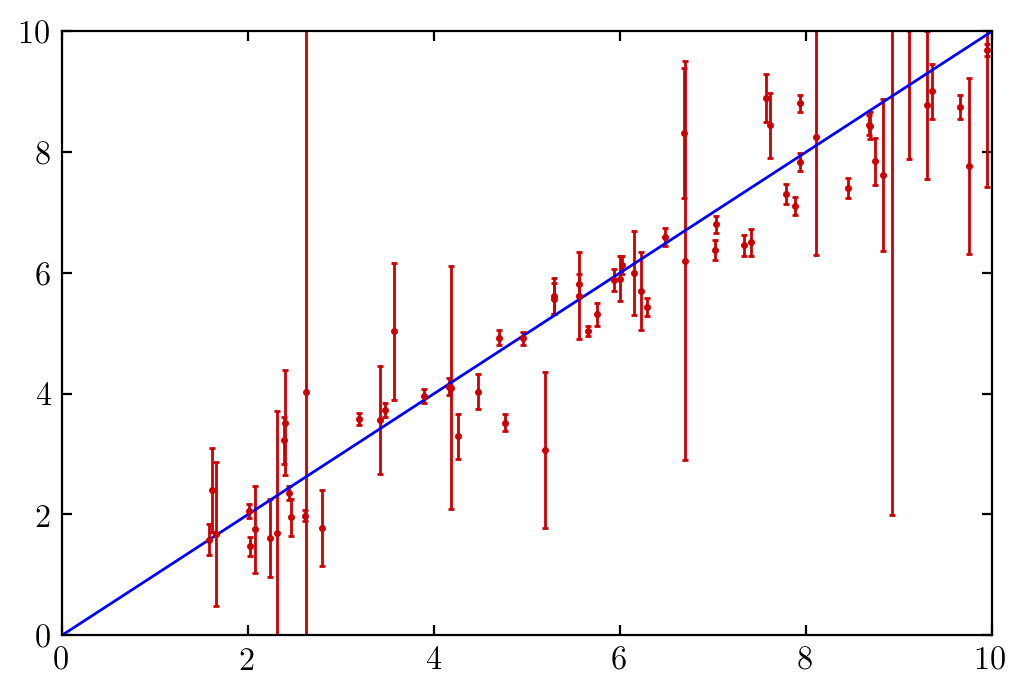

In [33]:
true = test_chi2.flatten()
pred = m.predict(test_samples, kern=m.kern.rbf)
gp = pred[0].flatten()
gp_err = pred[1].flatten()


lim = 1e1
_, ax = plt.subplots()
ax.errorbar(true, gp, yerr=gp_err, ls="", marker=".")
ax.plot([0, lim], [0, lim])
ax.set(xlim=(0, lim), ylim=(0, lim))

## MCMC

In [92]:
def lnprob(x):
    # need an invalid check here.
    return -m.predict(x.reshape((1, -1)), kern=m.kern.rbf)[0][0][0]

ndim, nwalkers = 5, 20
p0 = [samples[i] for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, a=1.1)

In [98]:
pos, prob, state = sampler.run_mcmc(p0, 200)
sampler.reset()

In [102]:
sampler.run_mcmc(pos, 100);

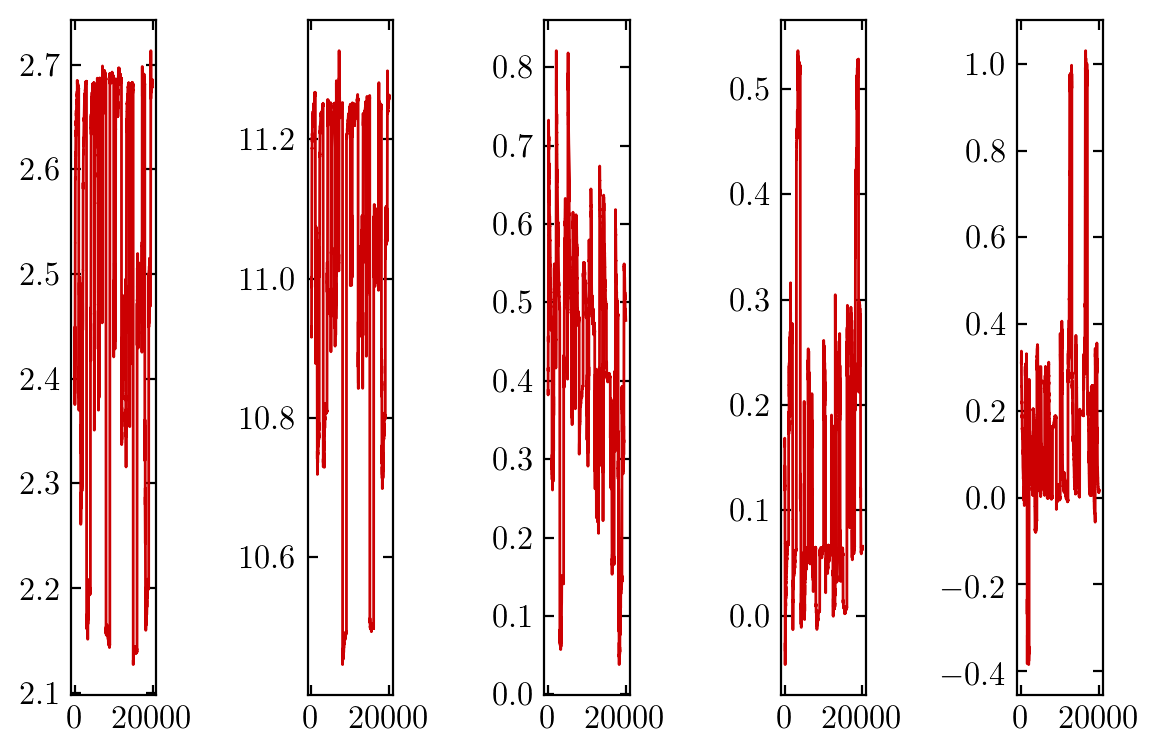

In [100]:
_, axes = plt.subplots(1, 5)
for i in range(ndim):
    axes[i].plot(sampler.flatchain[:,i])
plt.tight_layout()

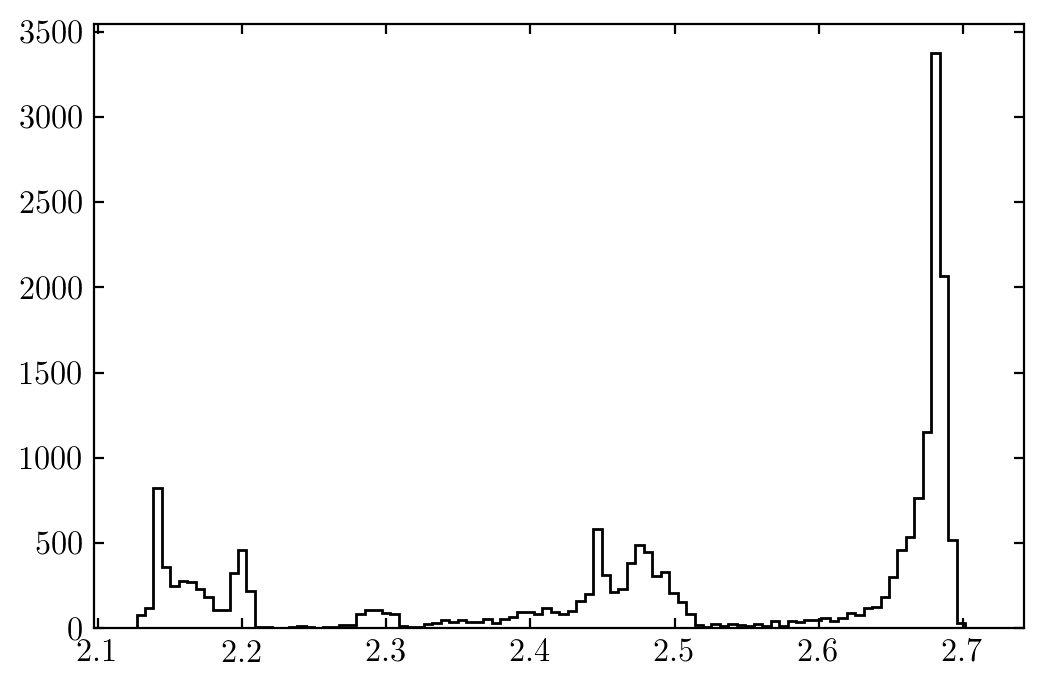

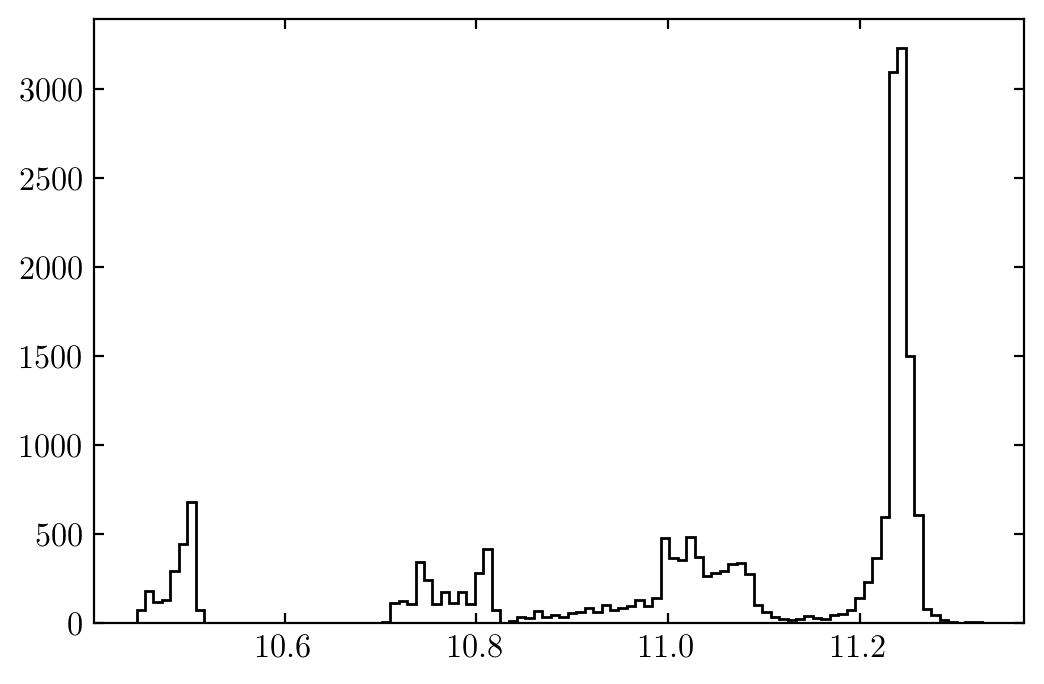

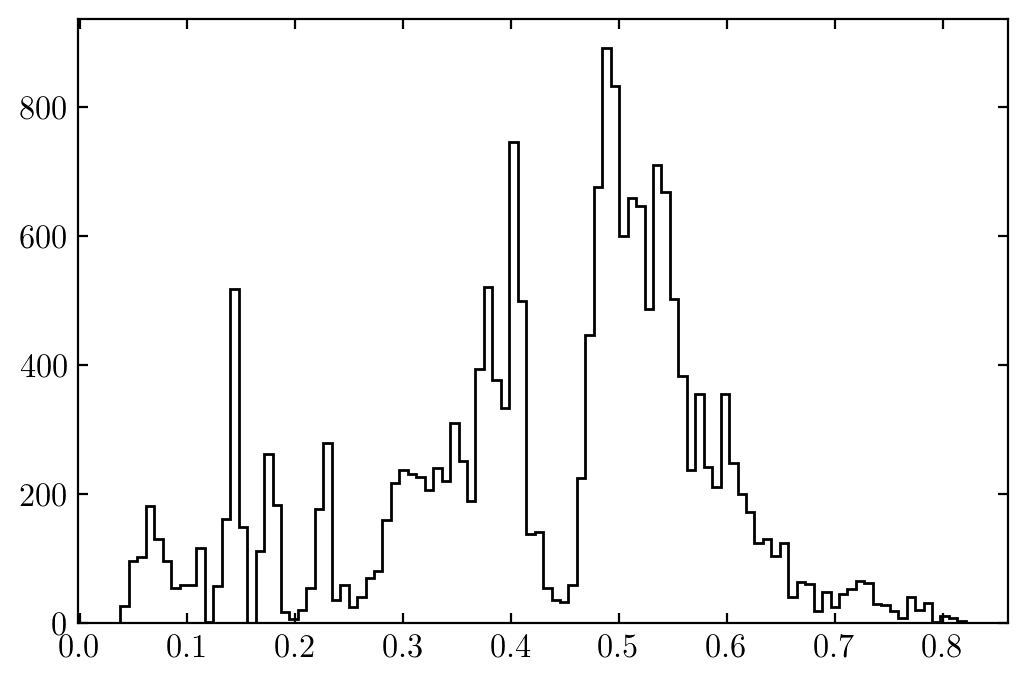

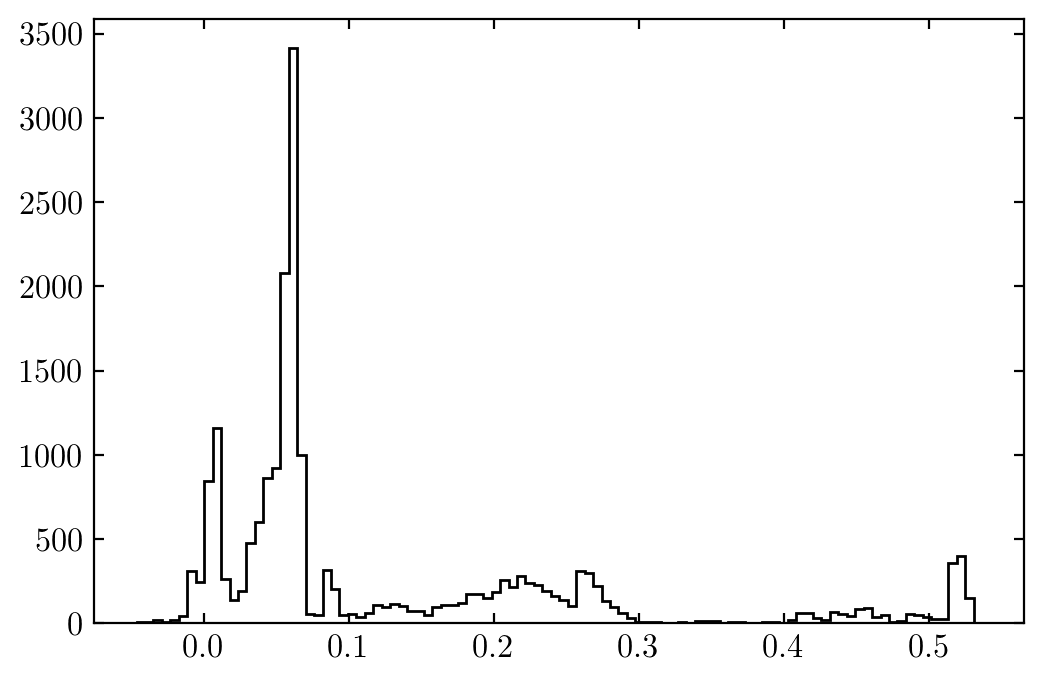

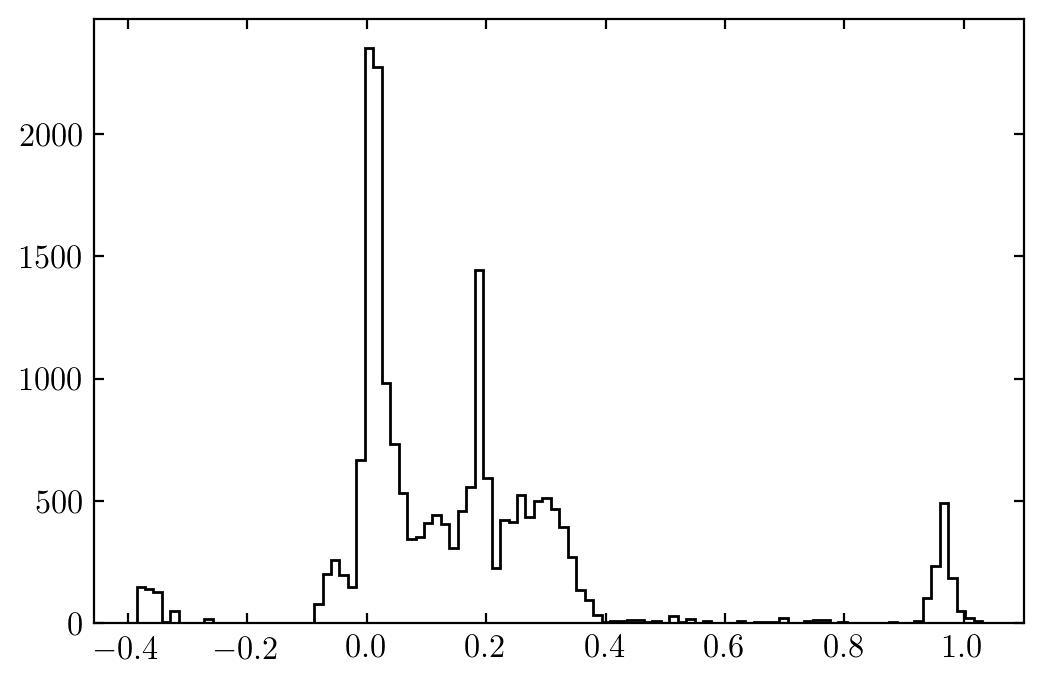

In [101]:
for i in range(ndim):
    _, ax = plt.subplots()
    ax.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    #ax.title("Dimension {0:d}".format(i))

# Build bestfit model and compare to observations

In [163]:
log_stellar_masses = get_sm_for_sim(sim_data, best_fit[:5], best_fit[5:], x_field)

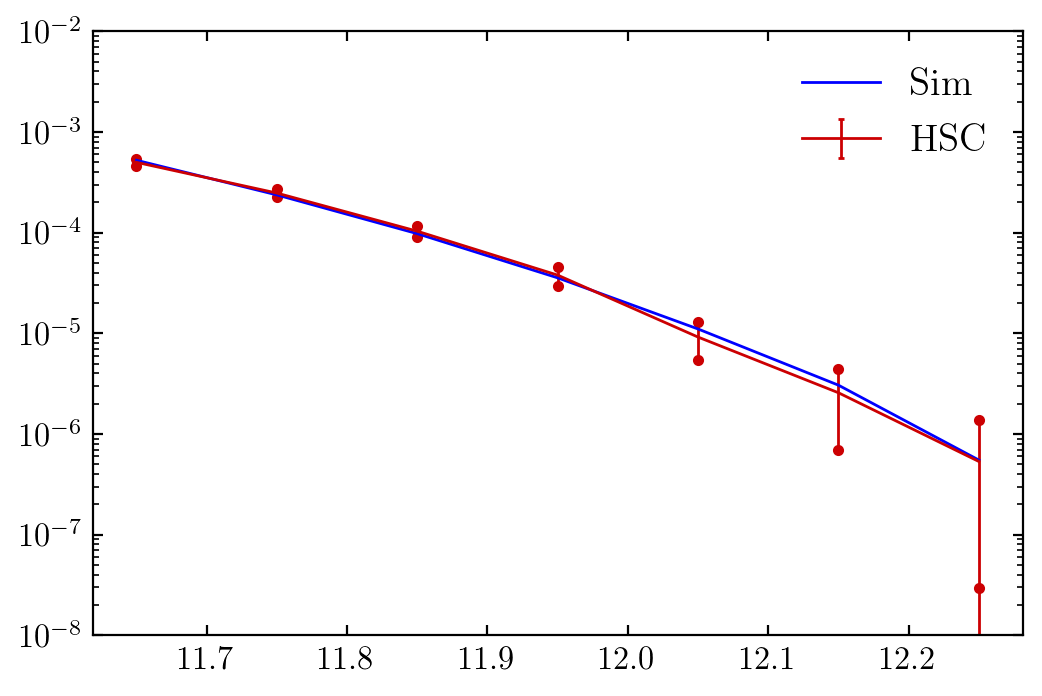

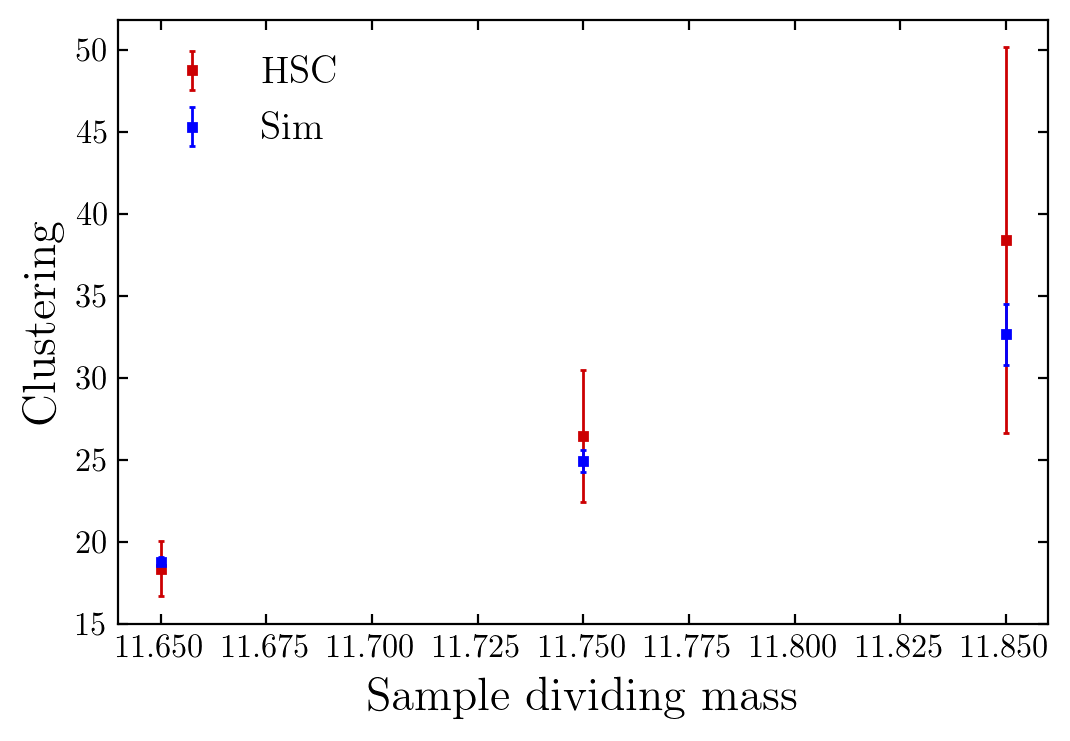

In [183]:
fig, ax = p.plot_smfs(obs_smf, log_stellar_masses, sim_size)
ax.set(ylim=(1e-8, 1e-2));

sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_smf.png", dpi=300)

fig, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.legend()

ax.set(ylabel="Clustering", xlabel="Sample dividing mass")
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_clust.png", dpi=300)

# Save out mock

In [9]:
sim_data_out = np.lib.recfunctions.append_fields(sim_data, names="stellar_mass", dtypes=np.float64, data=np.power(10, log_stellar_masses))
sim_data_out = np.lib.recfunctions.rename_fields(sim_data_out, {"halo_mvir": "Mpeak"})
np.save("mocks/new", np.ma.getdata(sim_data_out))

# From meeting

In [1]:
sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])

_, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.legend()

ax.set(ylabel="Clustering", xlabel="Sample dividing mass")

NameError: name 'np' is not defined